<header style="text-align: center; padding: 20px;">
  <h1 style="font-size: 2.5em; margin-bottom: 0.2em;">Financial Time Series Analysis</h1>
  <h2 style="font-weight: normal; font-size: 1.5em; color: #555;">Multivariate GARCH and Var Analysis</h2>
  <p style="font-size: 1.1em; color: #888;">Project | Time Series Analysis | Spring 2025</p>
  <hr style="margin-top: 20px; border: none; border-top: 1px solid #ccc;">
</header>


# Explanatory Data Analysis - **EDA**

In [ ]:
#! pip install -q investpy
#! pip install -q requests-cache
#! pip install -q yfinance
#! pip install --upgrade matplotlib
#! pip install matplotlib
! pip install pandas-datareader

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf  # equivalent to quantmod
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess
from arch import arch_model  
from scipy import stats
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import warnings
from curl_cffi import requests

import requests_cache
import investpy
import pickle
import os

# Display settings
# plt.style.use('seaborn')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from data_engineering import DataDownloader 
downloader = DataDownloader() #create isance of the class in our main method


import matplotlib.cbook as cbook
import matplotlib.dates as mdates

from statsmodels.stats.stattools import jarque_bera
from scipy.stats import norm
import statsmodels.api as sm

## Data Alignment and Missing Value Handling

In this section, we addressed a key issue in working with a portfolio composed of heterogeneous financial instruments: **differences in trading calendars**. Specifically, our portfolio includes:

- Equities (Boeing, traded on NYSE)
- Equity Index (S&P 500)
- Commodity (Gold)
- Currency (USD/PLN)
- Cryptocurrency (Ethereum)

### Problem

Some of these assets (like Ethereum) are traded **7 days a week**, while others (like Boeing and SP500) follow **standard business calendars**, excluding weekends and public holidays. This discrepancy leads to **asynchronous time series** and a misalignment of data points, which can significantly impact:

- Log-returns computation
- Portfolio aggregation
- Volatility modeling (especially GARCH models)
- Value-at-Risk estimation

### Our Approach

To ensure consistency across all time series:

1. **All assets were reindexed to business days (`freq='B'`)** to create a uniform temporal structure based on a 5-day trading week.
2. We identified the asset with the **highest number of missing values** after reindexing.
3. We used that asset’s index as the **reference calendar** for all other series.
4. We applied **forward fill (`ffill`)** to propagate last valid observations and eliminate remaining NaN values.

This guarantees:
- Fully aligned data across all assets
- Absence of NaNs in both training (2020-05-01 to 2024-04-30) and test (2024-05-01 to 2025-04-30) periods

### Alternatives Considered (But Not Used)

- **Mixed-Frequency Handling (e.g., MIDAS, Asynchronous GARCH)**: These methods are more complex, require advanced econometric models, and are less suitable for the rolling window VaR analysis required in this project.
- **Interpolation over weekends**: Discarded to avoid introducing artificial returns and distortions in volatility dynamics.

### Justification

While forward filling may mask some weekend moves (especially for crypto), the **impact is negligible**:
- Crypto contributes **only 20%** to the equally weighted portfolio.
- Business-day filtering leads to **only minor information loss**.
- Ensures a cleaner, synchronous dataset suitable for standard econometric modeling.


By taking this approach, we ensured that all subsequent analyses—return computation, portfolio construction, GARCH estimation, and Value-at-Risk simulation—are built on a clean and consistent foundation.


In [2]:
tickers = ['^GSPC', 'BA', 'ETH-USD', 'PLN=X', 'GC=F']
data_dict = downloader.load_or_download_data(tickers, start='2020-05-01', end='2025-05-01') #call external class to download

## NB: questi sono i dataset con TUTTE LE DATE!! --> vanno splittati in In-sample (train) e oos (test)
gspc_full = data_dict.get('gspc')
ba_full = data_dict.get('ba')
eth_full = data_dict.get('ethusd')
usdpln_full = data_dict.get('plnx')
gold_full = data_dict.get('gcf')

#Test set
# Data di split
split_date = '2024-05-01'

# Funzione per splittare un dataframe
def split_train_test(df, split_date):
    train = df[df.index < split_date]
    test = df[df.index >= split_date]
    return train, test

# Splitting
gspc_train, gspc_test = split_train_test(gspc_full, split_date)
ba_train, ba_test = split_train_test(ba_full, split_date)
eth_train, eth_test = split_train_test(eth_full, split_date)
usdpln_train, usdpln_test = split_train_test(usdpln_full, split_date)
gold_train, gold_test = split_train_test(gold_full, split_date)

# Controllo rapido
for name, df_train, df_test in [
    ("GSPC", gspc_train, gspc_test),
    ("BA", ba_train, ba_test),
    ("ETH-USD", eth_train, eth_test),
    ("USD/PLN", usdpln_train, usdpln_test),
    ("Gold", gold_train, gold_test)
]:
    print(f"{name} — Train: {df_train.shape}, Test: {df_test.shape}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


✅ Data downloaded and saved successfully.
GSPC — Train: (1461, 5), Test: (365, 5)
BA — Train: (1461, 5), Test: (365, 5)
ETH-USD — Train: (1461, 5), Test: (365, 5)
USD/PLN — Train: (1461, 5), Test: (365, 5)
Gold — Train: (1461, 5), Test: (365, 5)


In [4]:
# Copia originale dei DataFrame
train_dfs = {
    "GSPC": gspc_train.copy(),
    "BA": ba_train.copy(),
    "ETH-USD": eth_train.copy(),
    "USD/PLN": usdpln_train.copy(),
    "Gold": gold_train.copy()
}

test_dfs = {
    "GSPC": gspc_test.copy(),
    "BA": ba_test.copy(),
    "ETH-USD": eth_test.copy(),
    "USD/PLN": usdpln_test.copy(),
    "Gold": gold_test.copy()
}

def align_dataframes_consistently(dfs):
    original_shapes = {name: df.shape for name, df in dfs.items()}
    previous_len = None
    while True:
        common_index = sorted(set.intersection(*(set(df.index) for df in dfs.values())))
        for key in dfs:
            dfs[key] = dfs[key].reindex(common_index).dropna()
        current_len = len(set.intersection(*(set(df.index) for df in dfs.values())))
        if current_len == previous_len:
            break
        previous_len = current_len
    final_shapes = {name: df.shape for name, df in dfs.items()}
    return dfs, original_shapes, final_shapes

# Allinea train set
print("=== CHANGES TO TRAIN SETS (stable iteration) ===")
train_dfs_aligned, train_original_shapes, train_final_shapes = align_dataframes_consistently(train_dfs)
for name in train_dfs:
    print(f"{name} — Before: {train_original_shapes[name]}, After: {train_final_shapes[name]}")
    if name == "GSPC":
        gspc_train = train_dfs_aligned[name]
    elif name == "BA":
        ba_train = train_dfs_aligned[name]
    elif name == "ETH-USD":
        eth_train = train_dfs_aligned[name]
    elif name == "USD/PLN":
        usdpln_train = train_dfs_aligned[name]
    elif name == "Gold":
        gold_train = train_dfs_aligned[name]

# Allinea test set
print("\n=== CHANGES TO TEST SETS (stable iteration) ===")
test_dfs_aligned, test_original_shapes, test_final_shapes = align_dataframes_consistently(test_dfs)
for name in test_dfs:
    print(f"{name} — Before: {test_original_shapes[name]}, After: {test_final_shapes[name]}")
    if name == "GSPC":
        gspc_test = test_dfs_aligned[name]
    elif name == "BA":
        ba_test = test_dfs_aligned[name]
    elif name == "ETH-USD":
        eth_test = test_dfs_aligned[name]
    elif name == "USD/PLN":
        usdpln_test = test_dfs_aligned[name]
    elif name == "Gold":
        gold_test = test_dfs_aligned[name]


=== CHANGES TO TRAIN SETS (stable iteration) ===
GSPC — Before: (1006, 5), After: (1006, 5)
BA — Before: (1006, 5), After: (1006, 5)
ETH-USD — Before: (1006, 5), After: (1006, 5)
USD/PLN — Before: (1006, 5), After: (1006, 5)
Gold — Before: (1006, 5), After: (1006, 5)

=== CHANGES TO TEST SETS (stable iteration) ===
GSPC — Before: (249, 5), After: (249, 5)
BA — Before: (249, 5), After: (249, 5)
ETH-USD — Before: (249, 5), After: (249, 5)
USD/PLN — Before: (249, 5), After: (249, 5)
Gold — Before: (249, 5), After: (249, 5)


### Technical Considerations – Data Alignment

One of the main issues in working with financial time series is the **difference in trading calendars** between asset classes:

- **FX, cryptocurrencies, and commodities** are traded **continuously**, including weekends and many public holidays.
- **Stocks and ETFs**, however, follow the **U.S. NYSE trading calendar**, which consists of:
  - **5 trading days per week** (Monday to Friday)
  - **Exclusion of U.S. market holidays**


### Alignment Strategy

To ensure consistency across all datasets, we adopt the **Stock Exchange calendar (NYSE)** as our reference. This means:

- We reindex all continuous trading instruments (such as FX or crypto) to match the **stock market trading days**.
- Trading data available on weekends or holidays for these continuous assets is treated as **after-hours activity** and is **excluded** from our analysis.

This approach ensures all datasets share a **common and aligned time index**, making them suitable for comparison, modeling, and joint analysis.


### 📌 Note: Naming Convention for Train/Test DataFrames

For each financial asset, the dataset has been split into two subsets:

- **Train set**: includes data before the split date (`2024-05-01`).
- **Test set**: includes data from `2024-05-01` onward.

The DataFrames follow this naming convention:

| Asset          | Train DataFrame     | Test DataFrame      |
|----------------|---------------------|----------------------|
| S&P 500        | `gspc_train`        | `gspc_test`          |
| Boeing         | `ba_train`          | `ba_test`            |
| Ethereum (ETH) | `eth_train`         | `eth_test`           |
| USD/PLN        | `usdpln_train`      | `usdpln_test`        |
| Gold           | `gold_train`        | `gold_test`          |

All datasets have been **aligned to a common calendar** and **cleaned of NaN values** after the split.


### 📌 Why Use In-Sample and Out-of-Sample Periods?

Splitting the data into **in-sample** and **out-of-sample** periods is essential for model development and evaluation:

- **In-Sample**: Used for estimating and fitting models. This is where parameters are learned and diagnostics are performed.
- **Out-of-Sample**: Used for testing the predictive performance of the model on unseen data, providing an unbiased assessment of its accuracy.

This approach helps prevent overfitting and ensures that the model generalizes well to future data, especially when calculating Value-at-Risk (VaR) using a rolling window.


# Closing prices displaying - In Sample

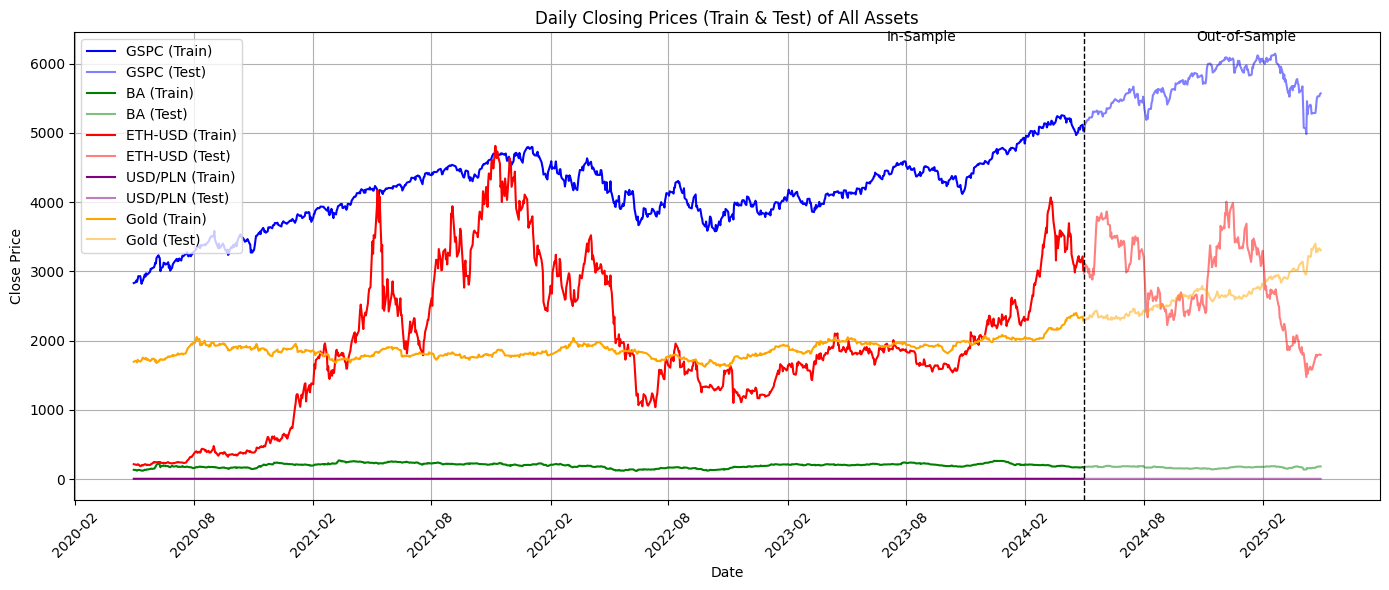

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Define color palette
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan']

# Mapping asset names to their in-sample and out-of-sample DataFrames
asset_data = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USD/PLN': (usdpln_train, usdpln_test),
    'Gold': (gold_train, gold_test)
}

# Split date for reference line
split_date = pd.to_datetime("2024-05-01")

# Start the plot
plt.figure(figsize=(14, 6))

# Plot each asset's in-sample and out-of-sample closing prices
for i, (name, (df_train, df_test)) in enumerate(asset_data.items()):
    color = colors[i % len(colors)]
    
    if 'Close' in df_train.columns and 'Close' in df_test.columns:
        # In-sample
        plt.plot(df_train.index, df_train['Close'], label=f'{name} (Train)', color=color)
        # Out-of-sample
        plt.plot(df_test.index, df_test['Close'], label=f'{name} (Test)', color=color, alpha=0.5)

# Vertical line at split date
plt.axvline(x=split_date, color='black', linestyle='--', linewidth=1)

# Annotate In-Sample and Out-of-Sample
ymin, ymax = plt.ylim()
xmid = plt.xlim()
plt.text(x=split_date - pd.Timedelta(days=250), y=ymax * 0.98, s="In-Sample", ha='center', fontsize=10, color='black')
plt.text(x=split_date + pd.Timedelta(days=250), y=ymax * 0.98, s="Out-of-Sample", ha='center', fontsize=10, color='black')

# Format axes
plt.title('Daily Closing Prices (Train & Test) of All Assets')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In order to appreciate the changing on PLN/USD asset we need to plot it alone instahed of rescale

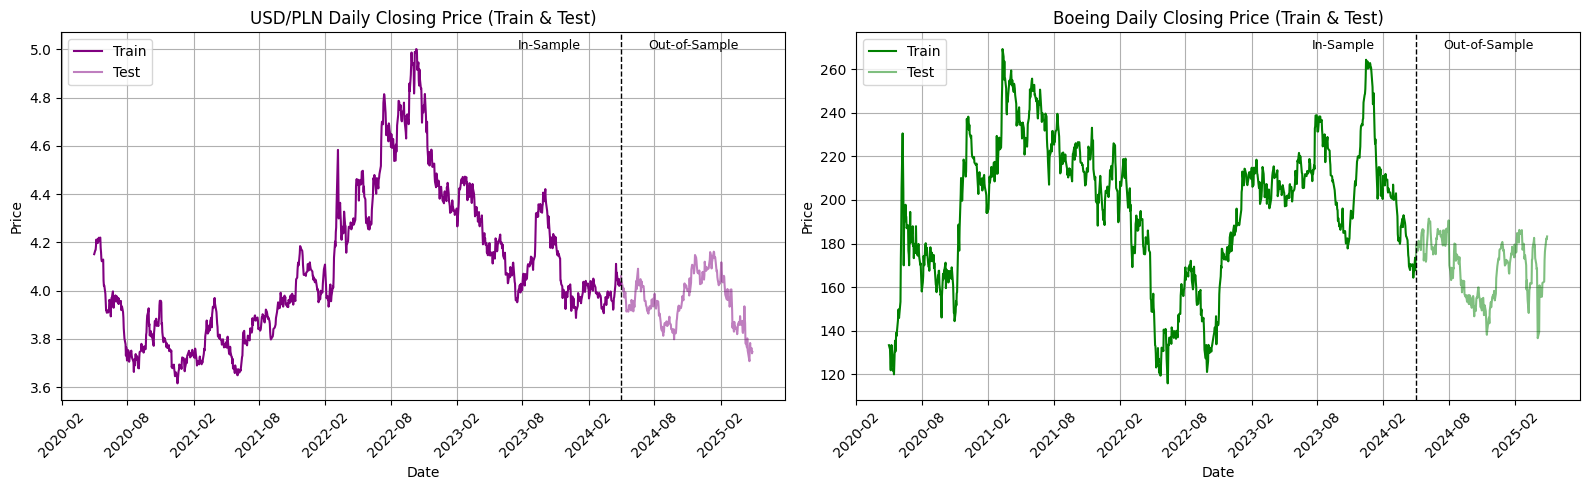

In [6]:
# In-sample and out-of-sample data
usdpln_train_df = usdpln_train.copy()
usdpln_test_df = usdpln_test.copy()
boeing_train_df = ba_train.copy()
boeing_test_df = ba_test.copy()

# Date of split
split_date = pd.to_datetime("2024-05-01")

if 'Close' in usdpln_train_df.columns and 'Close' in boeing_train_df.columns:

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

    # --- USD/PLN ---
    axes[0].plot(usdpln_train_df.index, usdpln_train_df['Close'], color='purple', label='Train')
    axes[0].plot(usdpln_test_df.index, usdpln_test_df['Close'], color='purple', alpha=0.5, label='Test')
    axes[0].axvline(x=split_date, color='black', linestyle='--', linewidth=1)
    axes[0].text(split_date - pd.Timedelta(days=200), usdpln_train_df['Close'].max(), 'In-Sample',
                 ha='center', fontsize=9)
    axes[0].text(split_date + pd.Timedelta(days=200), usdpln_train_df['Close'].max(), 'Out-of-Sample',
                 ha='center', fontsize=9)
    axes[0].set_title("USD/PLN Daily Closing Price (Train & Test)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Price")
    axes[0].grid(True)
    axes[0].legend()
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    axes[0].tick_params(axis='x', rotation=45)

    # --- Boeing ---
    axes[1].plot(boeing_train_df.index, boeing_train_df['Close'], color='green', label='Train')
    axes[1].plot(boeing_test_df.index, boeing_test_df['Close'], color='green', alpha=0.5, label='Test')
    axes[1].axvline(x=split_date, color='black', linestyle='--', linewidth=1)
    axes[1].text(split_date - pd.Timedelta(days=200), boeing_train_df['Close'].max(), 'In-Sample',
                 ha='center', fontsize=9)
    axes[1].text(split_date + pd.Timedelta(days=200), boeing_train_df['Close'].max(), 'Out-of-Sample',
                 ha='center', fontsize=9)
    axes[1].set_title("Boeing Daily Closing Price (Train & Test)")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Price")
    axes[1].grid(True)
    axes[1].legend()
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

else:
    print("USD/PLN or Boeing data not found or missing 'Close' column.")


---
# **Investigating returns**
## 1. Single indeces

### 1.1 Log Returns

From this point onward, we will use log-returns (i.e., the natural logarithm of price relatives) as our primary measure of asset returns throughout the analysis.
Log-returns are widely preferred in finance and econometrics for several reasons — to name just a few:

1. Time Additivity: Log-returns can be summed over time intervals, making them suitable for cumulative return calculations and for time series modeling.

2. Suitability for Volatility Modelling: GARCH-type models and other conditional volatility frameworks are typically applied to log-returns, as they often exhibit clearer volatility clustering and more regular statistical properties (as will become evident later in the analysis).

As a note, we calculate the log-returns using the closing price for the days t and t-1, so that we get the so said log-return 'close to close'. The choice of close-to-close log returns is not arbitrary but is motivated by their ability to incorporate both intra-day and overnight price dynamics.
Unlike returns computed over specific intraday intervals, close-to-close returns capture the full effect of market activity, including periods when the market is officially closed but price-relevant information is still being absorbed — such as after-hours news, earnings releases, or macroeconomic announcements.

This means that close-to-close returns embed a component of overnight volatility, which is particularly relevant for modeling total risk and for estimating volatility using GARCH-type models. Ignoring this component would lead to an underestimation of true return variability, especially in assets or markets that are sensitive to after-hours information flows.

We begin by plotting the daily log-returns for each of the five components: a stock (Boeing), a stock index (S&P 500), a cryptocurrency (Ethereum), a commodity (Gold), and a foreign exchange rate (USD/PLN).
These plots provide a preliminary visual inspection of the return behavior of each asset, highlighting possible volatility patterns, jumps, or outliers. In particular, we aim to identify early signs of heteroscedasticity and volatility clustering, which are key motivations for the use of GARCH-type models later in the analysis.

$$
r_{t}=\ln({\frac{P_t}{P_{t-1}}})
$$


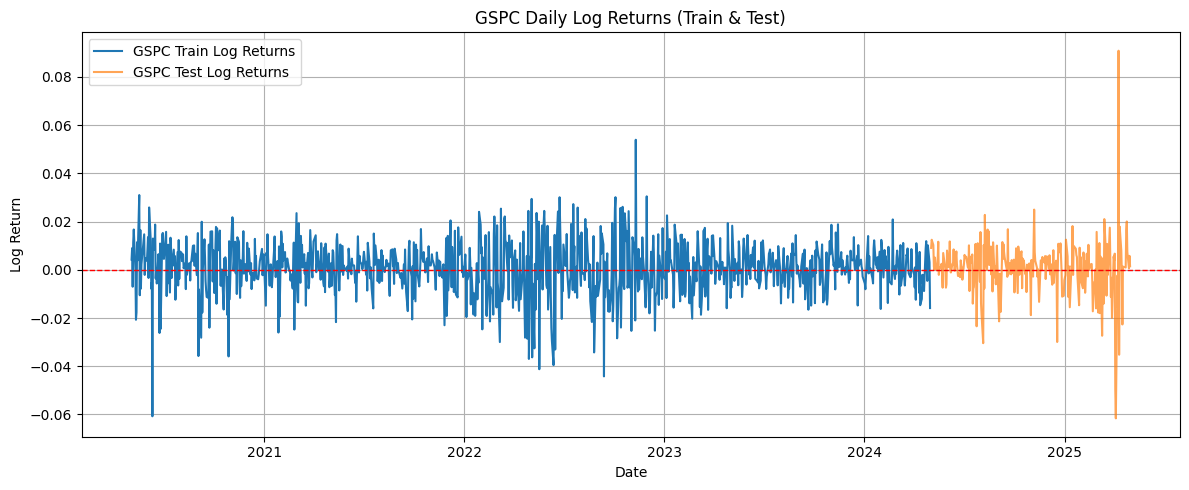

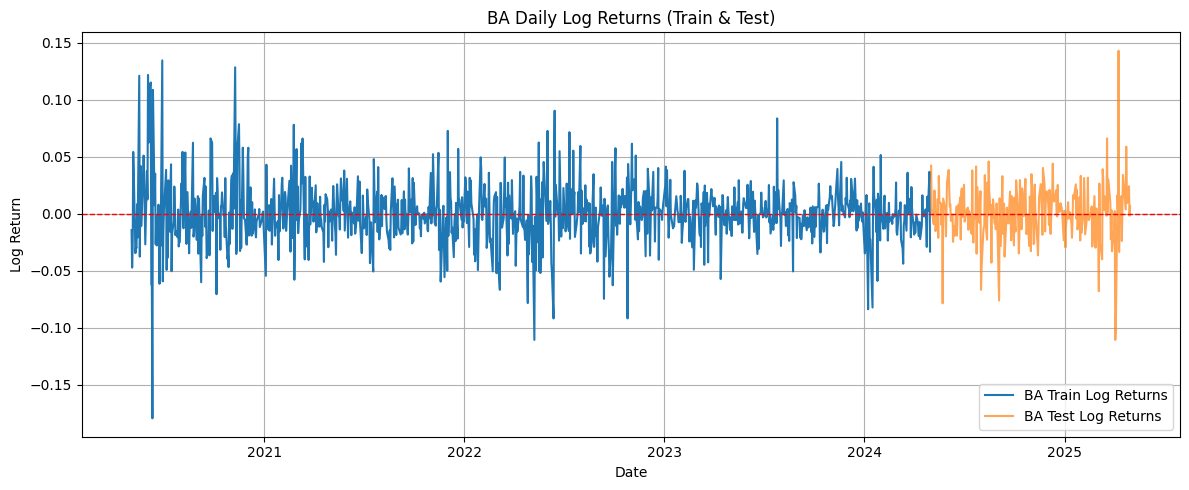

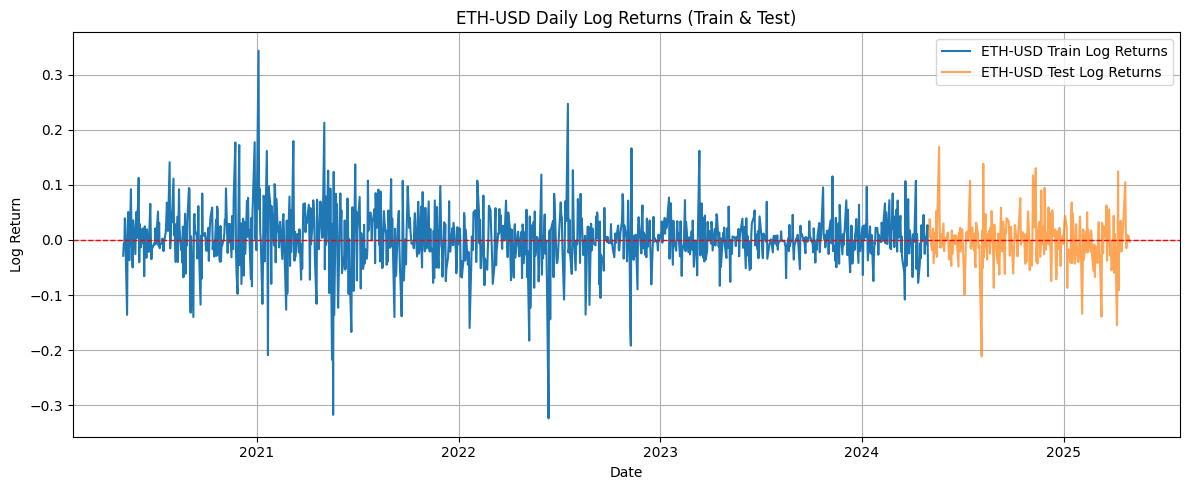

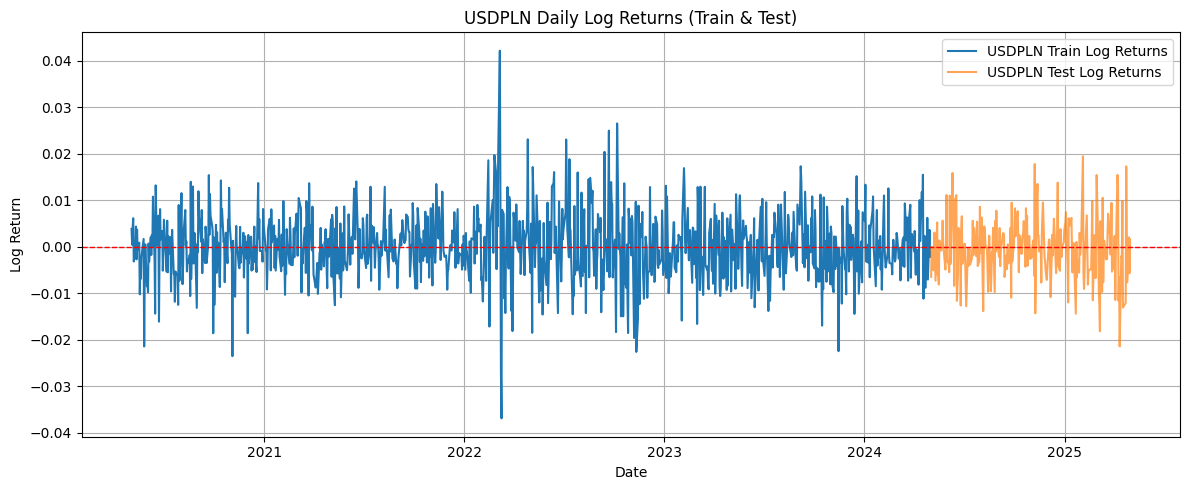

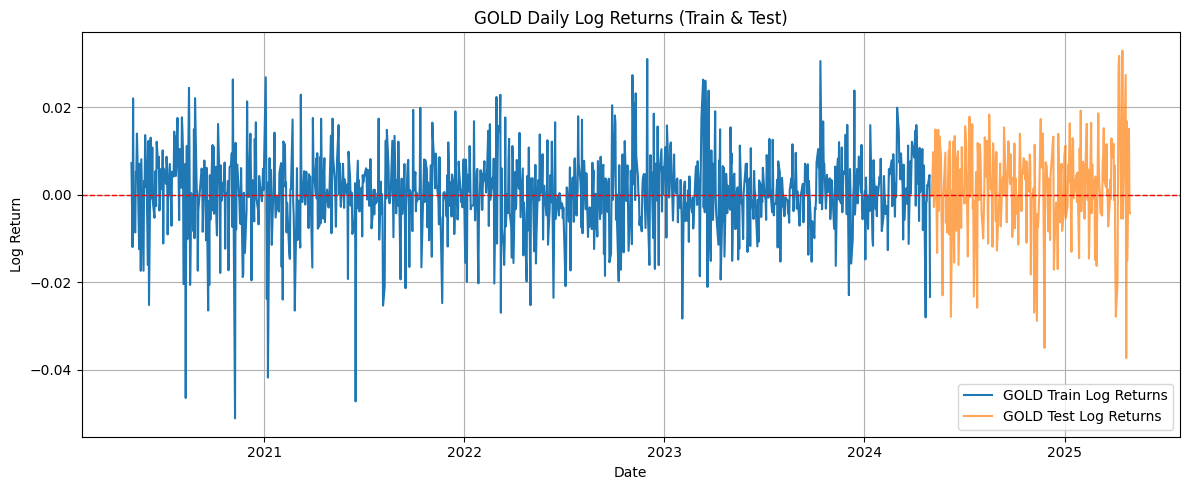

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Dizionario per salvare i log-return
log_return_dict = {}

# Lista degli asset e dei rispettivi DataFrame train/test
assets = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USDPLN': (usdpln_train, usdpln_test),
    'GOLD': (gold_train, gold_test)
}

for name, (df_train, df_test) in assets.items():
    # Calcola log-return per il train set
    train = df_train.copy()
    train['log_return'] = np.log(train['Close']).diff()
    log_return_dict[f'{name}_train_logReturn'] = train[['log_return']].dropna()

    # Calcola log-return per il test set
    test = df_test.copy()
    test['log_return'] = np.log(test['Close']).diff()
    log_return_dict[f'{name}_test_logReturn'] = test[['log_return']].dropna()

    # Plot (opzionale)
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['log_return'], label=f'{name} Train Log Returns')
    plt.plot(test.index, test['log_return'], label=f'{name} Test Log Returns', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.title(f'{name} Daily Log Returns (Train & Test)')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
for name, df in log_return_dict.items():
    print(f'>>> {name}.head()')
    print(df.head())
    print('\n' + '-'*50 + '\n')


### 1.2 Squared Log Returns

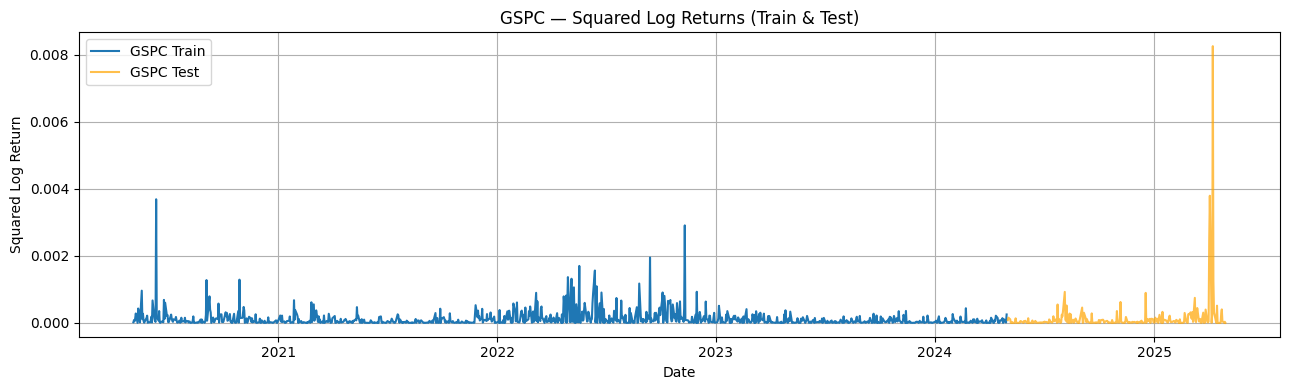

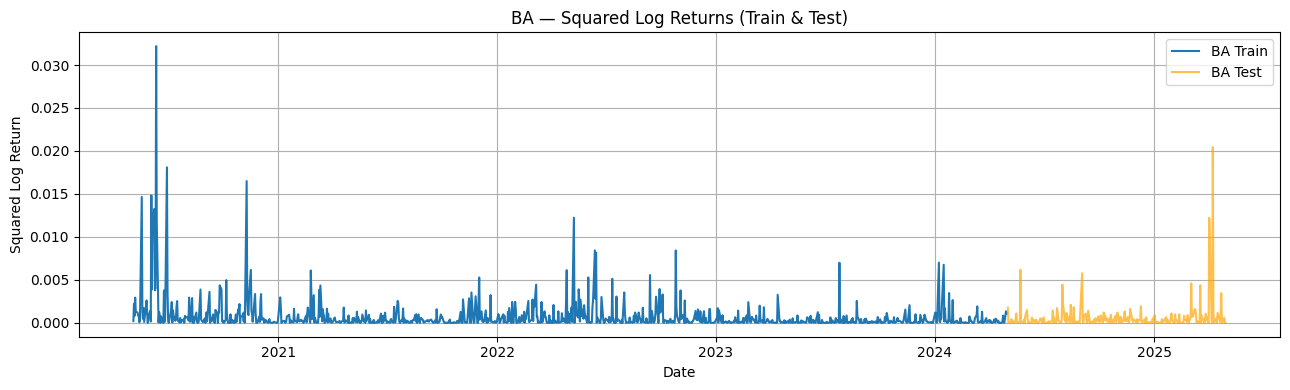

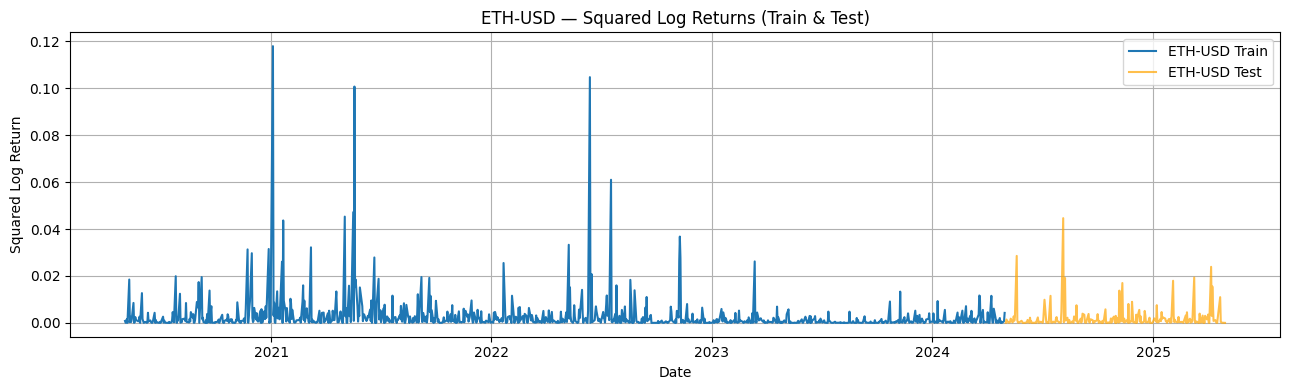

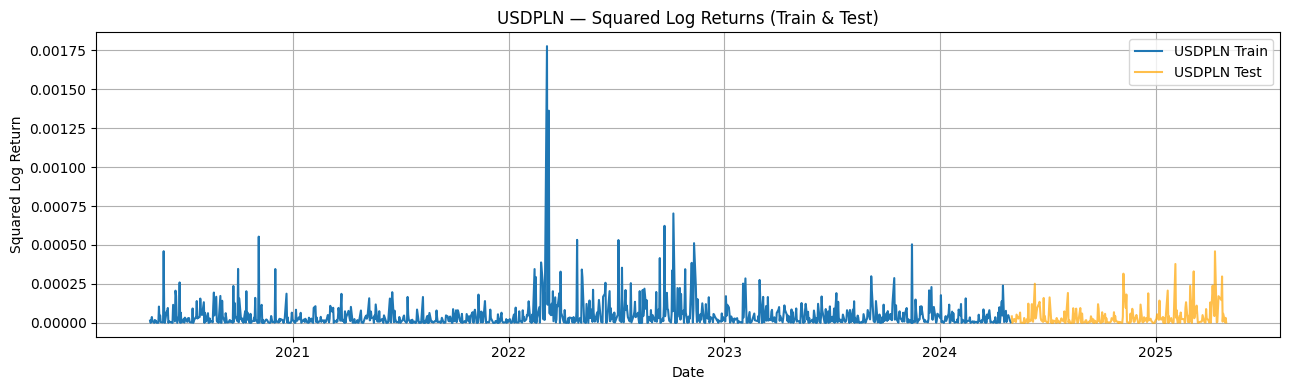

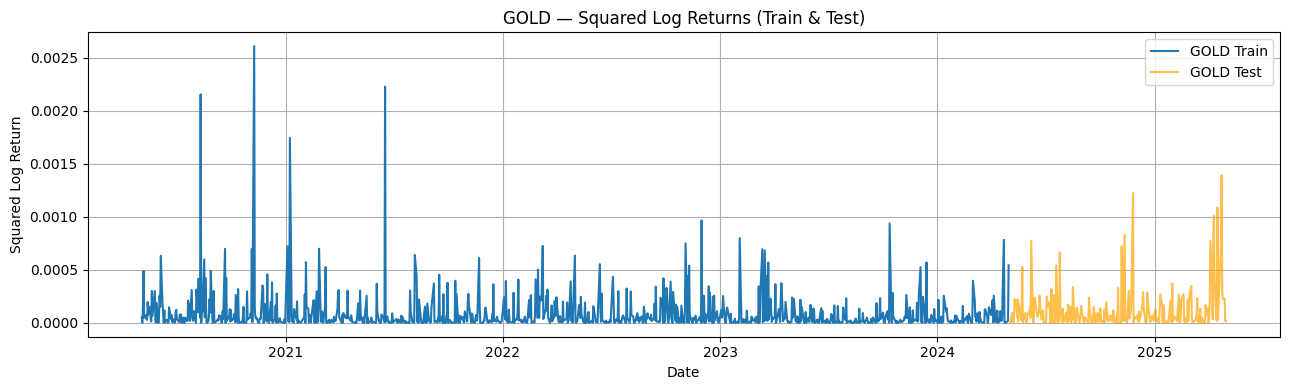

In [8]:
# Mapping of train/test DataFrames for each asset
assets = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USDPLN': (usdpln_train, usdpln_test),
    'GOLD': (gold_train, gold_test)
}

# Compute and plot squared log-returns for each period (train and test)
for name, (df_train, df_test) in assets.items():
    # In-sample period
    train = df_train.copy()
    train['log_return'] = np.log(train['Close']).diff()
    train['squared_log_return'] = train['log_return'] ** 2

    # Out-of-sample period
    test = df_test.copy()
    test['log_return'] = np.log(test['Close']).diff()
    test['squared_log_return'] = test['log_return'] ** 2

    # Plot squared log-returns for both periods
    plt.figure(figsize=(13, 4))
    plt.plot(train.index, train['squared_log_return'], label=f'{name} Train')
    plt.plot(test.index, test['squared_log_return'], label=f'{name} Test', color='orange', alpha=0.7)
    plt.title(f'{name} — Squared Log Returns (Train & Test)')
    plt.xlabel('Date')
    plt.ylabel('Squared Log Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## 2. **Equally Weighted Portfolio**
### 2.1 Daily Log Returns 

The time series plots of daily log returns for all five assetes reveal a common and important empirical feature: heteroskedasticity, that is, the variance of returns varies over time. This is visually apparent through alternating periods of high volatility (large swings in returns) and low volatility (smaller, more stable fluctuations). Visual inspection provides valuable intuition, but it must be complemented with rigorous statistical tests to confirm the existence of ARCH effects (Autoregressive Conditional Heteroskedasticity), which are the foundation for GARCH-type models.

The next step involves computing the log return of the portfolio, defined as an equally weighted average of the five individual asset returns analyzed above. A fixed weight of 20% is assigned to each asset, representing a balanced allocation that gives equal importance to all components in the portfolio. As a consequence, we assume the portfolio is daily rebalanced to preserve these fixed weights over time. Under this assumption, the log-return of the portfolio can be computed as the weighted sum of the individual asset log-returns:
$$
r_{p,t} = \sum_{i=1}^{5} w_i \cdot r_{i,t}
$$

In [9]:
# Step 1: Create lists for in-sample and out-of-sample log returns
log_returns_train = []
log_returns_test = []

# Asset mapping
assets = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USDPLN': (usdpln_train, usdpln_test),
    'GOLD': (gold_train, gold_test)
}

# Step 2: Compute log returns and collect aligned series
for name, (df_train, df_test) in assets.items():
    # In-sample
    df_train = df_train.copy()
    df_train['log_return'] = np.log(df_train['Close']).diff()
    train_series = df_train[['log_return']].rename(columns={'log_return': name})
    log_returns_train.append(train_series)

    # Out-of-sample
    df_test = df_test.copy()
    df_test['log_return'] = np.log(df_test['Close']).diff()
    test_series = df_test[['log_return']].rename(columns={'log_return': name})
    log_returns_test.append(test_series)

# Step 3: Concatenate and align by date
log_return_train_df = pd.concat(log_returns_train, axis=1).dropna()
log_return_test_df = pd.concat(log_returns_test, axis=1).dropna()

# Step 4: Calculate equally weighted portfolio log returns
n_assets = log_return_train_df.shape[1]
log_return_train_df['portfolio'] = log_return_train_df.dot(np.repeat(1/n_assets, n_assets))

n_assets_test = log_return_test_df.shape[1]
log_return_test_df['portfolio'] = log_return_test_df.dot(np.repeat(1/n_assets_test, n_assets_test))

# Optional: print shape info
print("Train log return dataframe shape:", log_return_train_df.shape)
print("Test log return dataframe shape:", log_return_test_df.shape)


Train log return dataframe shape: (1005, 6)
Test log return dataframe shape: (248, 6)


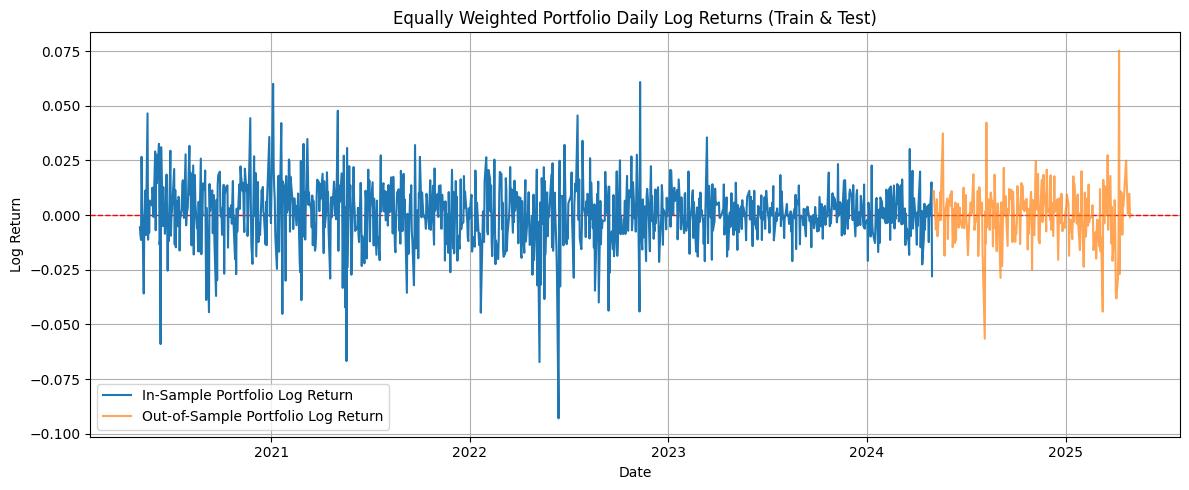

In [10]:
plt.figure(figsize=(12, 5))
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Plot in-sample
plt.plot(log_return_train_df.index, log_return_train_df['portfolio'], label='In-Sample Portfolio Log Return')

# Plot out-of-sample
plt.plot(log_return_test_df.index, log_return_test_df['portfolio'], label='Out-of-Sample Portfolio Log Return', alpha=0.7)

plt.title('Equally Weighted Portfolio Daily Log Returns (Train & Test)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Although diversification should reduce the magnitude of extreme movements compared to individual assets, noticeable fluctuations and persistent periods of high and low volatility still emerge. This justifies further investigation into the portfolio’s volatility dynamics using conditional heteroskedasticity models.

### 2.2 Squared Log Returns

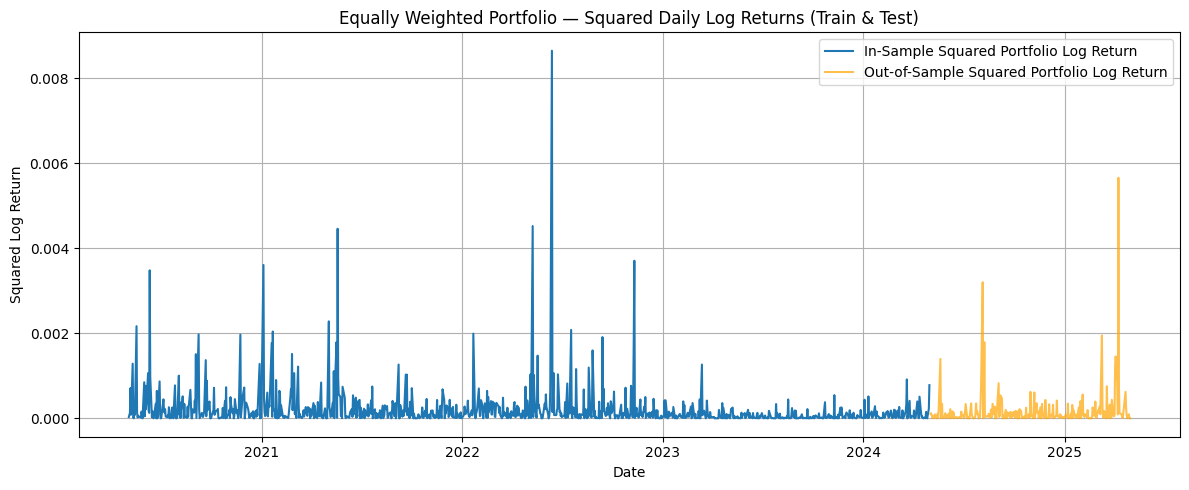

In [11]:
import matplotlib.pyplot as plt

# Step 5: Calculate squared log returns for the portfolio
log_return_train_df['squared_portfolio_return'] = log_return_train_df['portfolio'] ** 2
log_return_test_df['squared_portfolio_return'] = log_return_test_df['portfolio'] ** 2

# Step 6: Plot squared log returns of the equally weighted portfolio
plt.figure(figsize=(12, 5))

# Plot in-sample squared returns
plt.plot(log_return_train_df.index, log_return_train_df['squared_portfolio_return'],
         label='In-Sample Squared Portfolio Log Return')

# Plot out-of-sample squared returns
plt.plot(log_return_test_df.index, log_return_test_df['squared_portfolio_return'],
         label='Out-of-Sample Squared Portfolio Log Return', color='orange', alpha=0.7)

# Plot formatting
plt.title('Equally Weighted Portfolio — Squared Daily Log Returns (Train & Test)')
plt.xlabel('Date')
plt.ylabel('Squared Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


---
# **Returns Stylized Facts** (da aggiustare i commenti)

# 1. Commenting on possible *leptokurtosis* of log-returns

In this section, we examine the well-known empirical regularities of financial asset returns.  Specifically, we verify that daily log-returns typically display:

- **Mean close to zero**, indicating no persistent drift over time.  
- **Leptokurtosis**, with heavier tails than a Gaussian distribution.  
- **Approximate symmetry**, or mild negative skew, reflecting slightly more extreme down-moves.  
- **Weak autocorrelation**, consistent with the weak-form Efficient Market Hypothesis.

We will quantify these features via summary statistics, the Jarque–Bera normality test, and the Ljung–Box test for serial dependence. 


**NB**: *The analysis of stylized facts is performed only on the in-sample data because it is used to understand the statistical properties of the time series, such as volatility clustering, leptokurtosis, and the presence of ARCH effects. These characteristics guide the model selection and specification. The out-of-sample data is reserved for evaluating the forecasting performance of the fitted models and must remain untouched during model development to ensure a fair and unbiased assessment.*


In [12]:
# Mapping of in-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

lb_lags = [10]
results = []

# 1) Loop over each in-sample asset
for name, df in assets_train.items():
    df = df.copy()
    r = np.log(df['Close']).diff().dropna()

    # Jarque-Bera test
    jb_stat, jb_pvalue, skew, kurtosis_excess = jarque_bera(r)

    # Ljung–Box test for autocorrelation
    lb = acorr_ljungbox(r, lags=lb_lags, return_df=True)
    lb_stat = lb['lb_stat'].iloc[0]
    lb_pvalue = lb['lb_pvalue'].iloc[0]

    results.append({
        'Asset': name.upper(),
        'Mean(r)': r.mean(),
        'Skew(r)': skew,
        'Kurtosis(r)': kurtosis_excess + 3,  # convert to normal kurtosis
        'JB Stat': jb_stat,
        'JB p-value': jb_pvalue,
        f'LB{lb_lags[0]} Stat': lb_stat,
        f'LB{lb_lags[0]} p-value': lb_pvalue
    })

# 2) Equally weighted portfolio log-returns (in-sample)
rets = pd.concat(
    [np.log(df['Close']).diff() for df in assets_train.values()],
    axis=1
)
rets.columns = list(assets_train.keys())
rets = rets.dropna()

port_r = rets.mean(axis=1)

# Portfolio tests
jb_stat, jb_pvalue, skew, kurtosis_excess = jarque_bera(port_r)
lb = acorr_ljungbox(port_r, lags=lb_lags, return_df=True)
lb_stat = lb['lb_stat'].iloc[0]
lb_pvalue = lb['lb_pvalue'].iloc[0]

results.append({
    'Asset': 'PORTFOLIO',
    'Mean(r)': port_r.mean(),
    'Skew(r)': skew,
    'Kurtosis(r)': kurtosis_excess + 3,
    'JB Stat': jb_stat,
    'JB p-value': jb_pvalue,
    f'LB{lb_lags[0]} Stat': lb_stat,
    f'LB{lb_lags[0]} p-value': lb_pvalue
})

# 3) Summary table
summary_df = pd.DataFrame(results)
summary_df.index = np.arange(1, len(summary_df) + 1)

# Display
summary_df

,Asset,Mean(r),Skew(r),Kurtosis(r),JB Stat,JB p-value,LB10 Stat,LB10 p-value
1,GSPC,0.00057,-0.42759,8.24913,242.45195,0.00000,18.03505,0.05438
2,BA,0.00023,0.22472,10.64332,911.30264,0.00000,19.79610,0.03124
3,ETH-USD,0.00263,-0.20633,12.16579,1599.08976,0.00000,17.58512,0.06238
4,USDPLN,-0.00003,0.12024,8.14865,195.74656,0.00000,26.63574,0.00297
5,GOLD,0.00030,-0.54945,8.53903,320.52313,0.00000,16.71836,0.08083
6,PORTFOLIO,0.00074,-0.54238,9.69342,620.50495,0.00000,21.01022,0.02102


In [13]:
#save as CSV for further analysis
summary_df.to_csv('../data/results/stylized_facts_summary.csv', index=False)

## 1.1 Summary of Stylized Facts for In-Sample Log Returns

The statistical summary confirms the presence of several classic stylized facts in daily log returns:

- **Mean close to zero**: All assets show an average return near zero, from –0.00003 for USDPLN to +0.00181 for ETH-USD, consistent with no strong drift in daily movements.

- **Leptokurtosis**: All series display **excess kurtosis**, far above the Gaussian benchmark of 3. Kurtosis values range from ~8.25 for GSPC to over 11 for ETH-USD, reflecting frequent extreme returns and fat tails—typical of financial time series.

- **Mild skewness**: Skewness is moderate in magnitude. Most assets show slight negative asymmetry (GSPC, ETH-USD, GOLD, and the portfolio), while BA and USDPLN have mild positive skewness. These values indicate that return distributions are not perfectly symmetric.

- **Jarque–Bera test**: All assets have **very small p-values** (e.g., p < 1e-50), strongly rejecting the null hypothesis of normality. This reinforces the presence of both skewness and excess kurtosis.

- **Ljung–Box(10) test**: The test indicates **significant autocorrelation** in returns for BA, ETH-USD, USDPLN, and the equally-weighted portfolio (p < 0.05), while GSPC and GOLD are borderline. This suggests that raw return series are not fully white noise and may contain weak short-term memory, possibly due to microstructure effects or market inefficiencies.

These findings support the use of GARCH-type models to capture volatility dynamics, especially given the non-normality and serial dependence in returns.



## 1.2 Distributional Assessment via **KDE** and **QQ-Plots** (da aggiustare i commenti)

To complement the formal normality tests, we juxtapose each series’ empirical kernel‐density estimate (KDE) of its log-returns against the density of a Gaussian law with the same mean and variance, and we accompany that with a QQ-plot versus the matching theoretical normal quantiles.  The KDE highlights how the bulk and the tails of the true distribution depart from the bell curve, while the QQ-plot makes those departures explicit: systematic “S-shapes” betray leptokurtosis, and asymmetries around the 45° line flag skew.  Together, these visuals give an immediate sense of tail thickness, central peak height, and any bias in the left or right tail, all key stylized facts of financial returns.


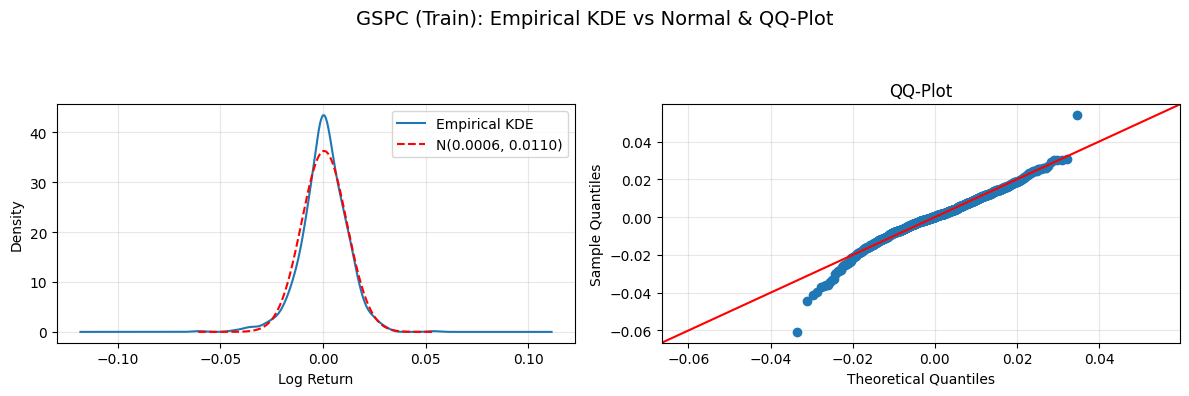

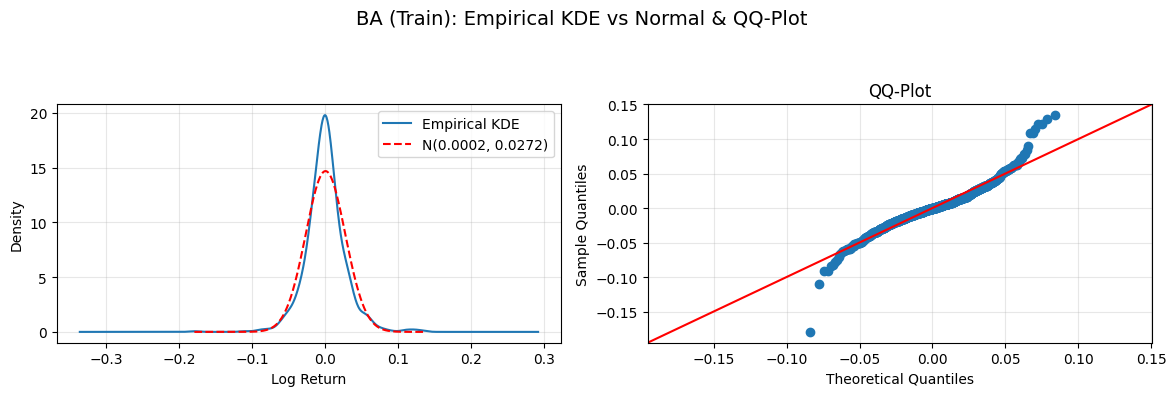

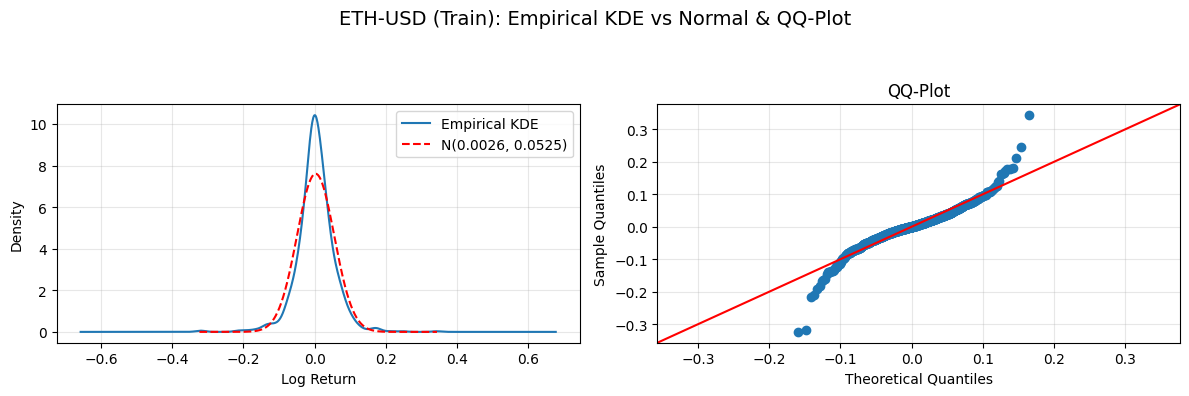

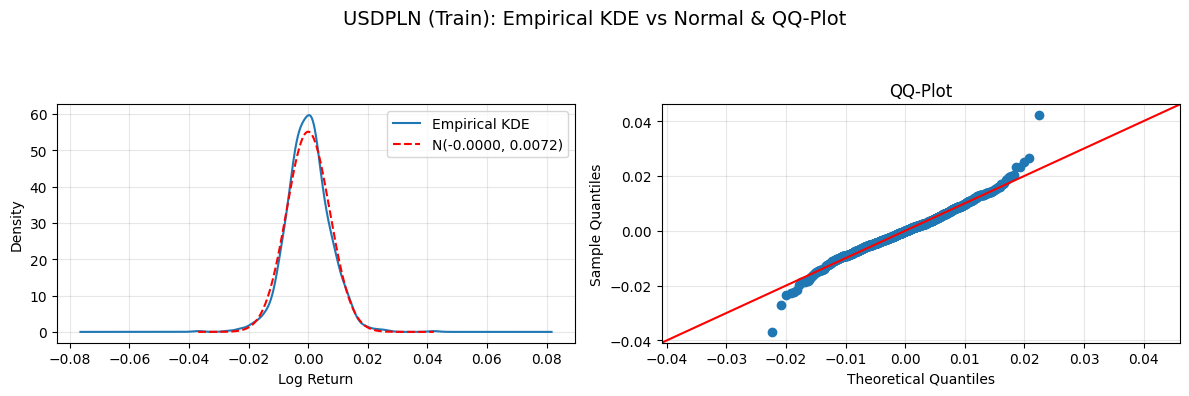

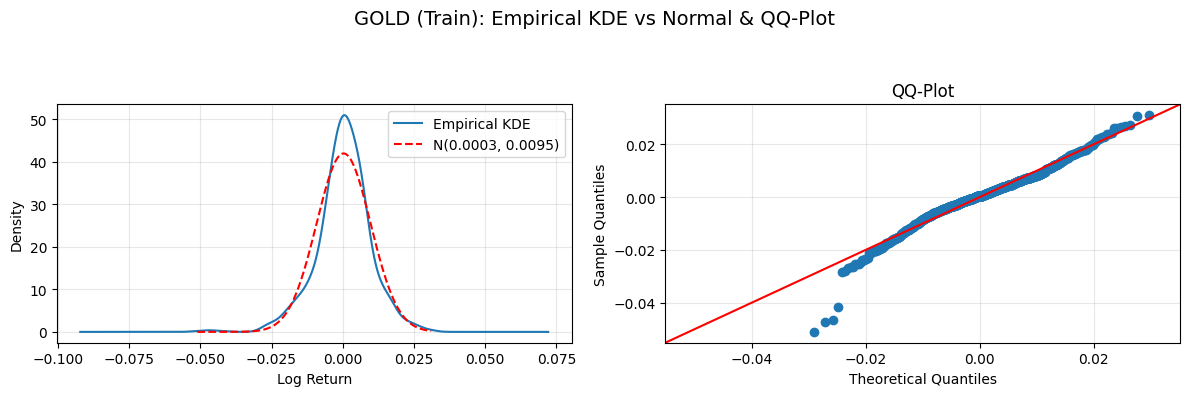

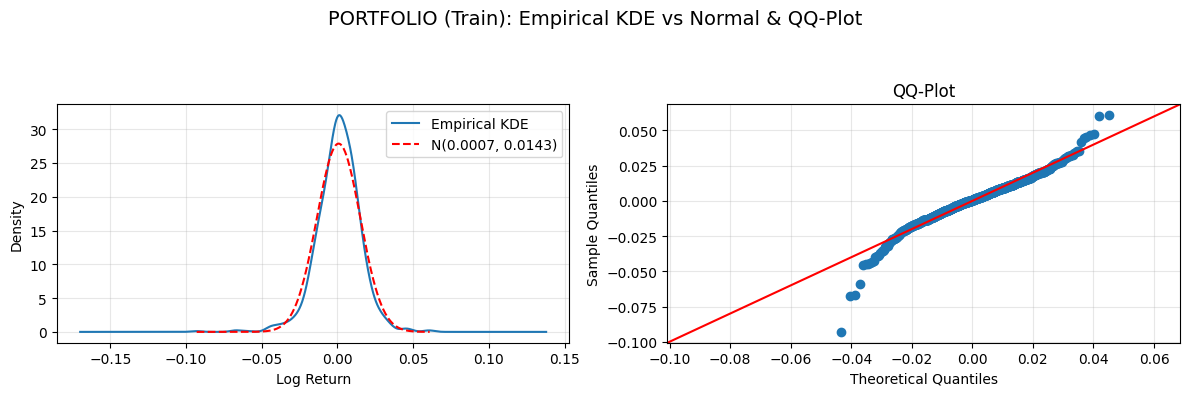

In [14]:
# Mapping of in-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

# Step 1: Compute log-returns for each asset (train only)
returns_dict = {}
for name, df in assets_train.items():
    r = np.log(df['Close']).diff().dropna()
    returns_dict[name.upper()] = r

# Step 2: Compute equally-weighted portfolio log-returns
asset_names = list(returns_dict.keys())
weights = np.repeat(1/len(asset_names), len(asset_names))
aligned = pd.concat([returns_dict[n] for n in asset_names], axis=1).dropna()
aligned.columns = asset_names
portfolio_r = aligned.dot(weights)
returns_dict['PORTFOLIO'] = portfolio_r

# Step 3: Plot KDE + QQ-Plot for each in-sample series
for name, r in returns_dict.items():
    mu, sigma = r.mean(), r.std()
    x_min, x_max = r.min(), r.max()
    x = np.linspace(x_min, x_max, 500)
    pdf = norm.pdf(x, loc=mu, scale=sigma)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"{name} (Train): Empirical KDE vs Normal & QQ‐Plot", fontsize=14)

    # 1) Density plot
    ax = axes[0]
    r.plot(kind='density', ax=ax, label='Empirical KDE')
    ax.plot(x, pdf, 'r--', label=f'N({mu:.4f}, {sigma:.4f})')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

    # 2) QQ‐Plot
    ax = axes[1]
    sm.qqplot(r, line='45', ax=ax, dist=norm, loc=mu, scale=sigma)
    ax.set_title('QQ‐Plot')
    ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# 2. Investigating **volatility stylized facts**


In this section, we explore the stylized facts of financial volatility, which are essential for understanding the empirical behavior of asset returns and for motivating the use of certain conditional volatility models.

In order to do so, a brief explanaton of the volatility is required:
Volatility is closely related to the likelihood of observing extreme values in asset returns — whether very high or very low. However, from a statistical perspective, volatility must be clearly distinguished from the unconditional variance of returns.
In fact, volatility is a forward-looking measure of risk: given a planned holding period [t,t+k] volatility is defined as the conditional variance of returns over that horizon, based on the information available at time 
𝑡. Formally:

$$
v_{t+k,k}=Var(r_{t+k,k}|\mathcal{I_t})=E[r^2_{t+k,k}|\mathcal{I_t}]-(E[r_{t+k,k}|\mathcal{I_t}])^2
$$

By conditioning on the information set $\mathcal{I_t}$, volatility becomes state-dependent, adapting to current market conditions. This is in stark contrast to the unconditional variance, which assumes constant risk over time and across all scenarios.
As a result, volatility is considered a latent variable — it cannot be observed directly, but must be inferred through appropriate models.
To study volatility empirically, we rely on observable proxies. In this analysis, we adopt the squared log-returns as our primary proxy. This choice is both practical and theoretically sound, as squared returns reflect the magnitude of return fluctuations regardless of direction and align naturally with the structure of ARCH and GARCH models; indeed, if we assume (and, in general, this hypothesis is true) that the returns are zero mean, the squared log-return is an unbiased estimator for the volatility:
$$
E[v_t]=E[r^2_t]
$$

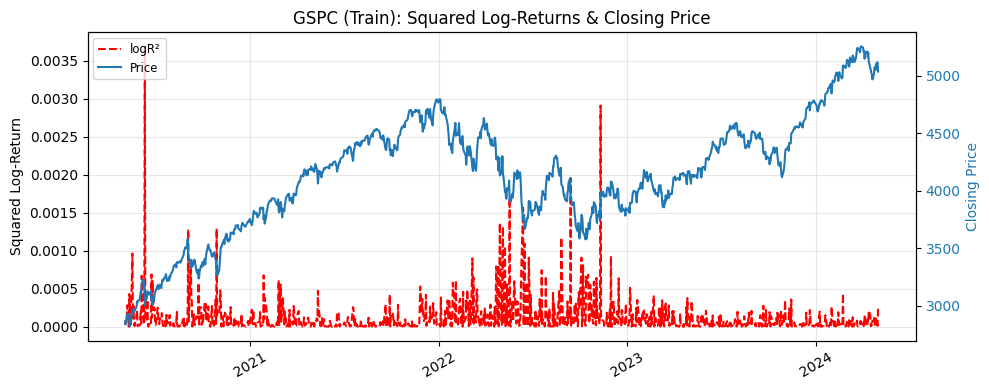

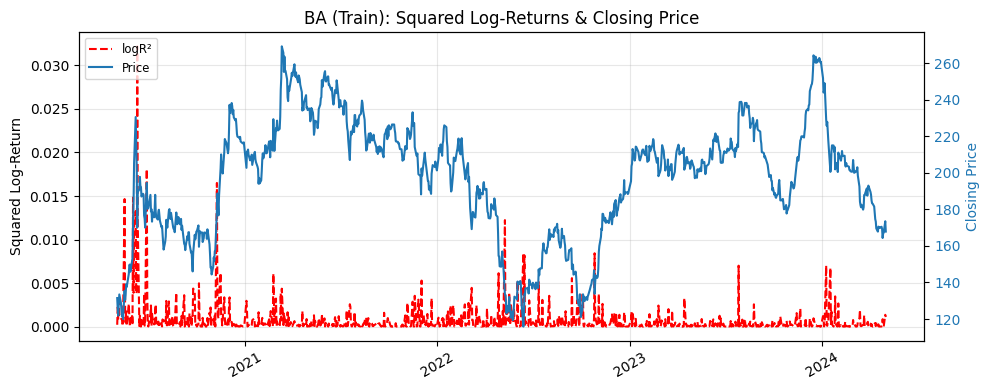

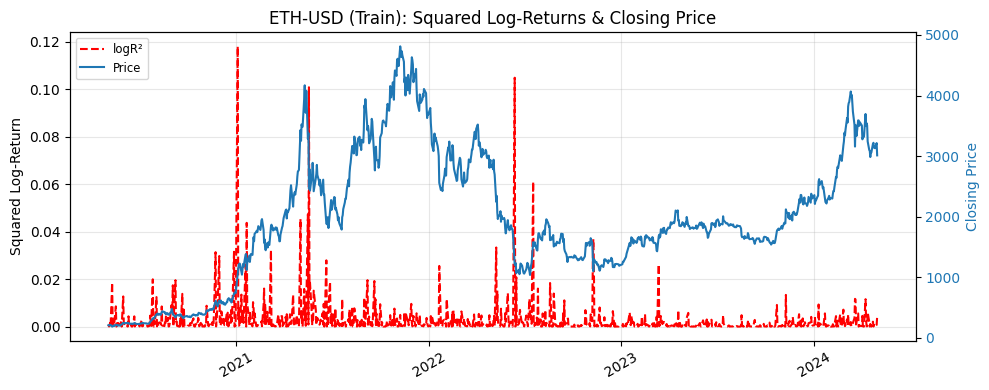

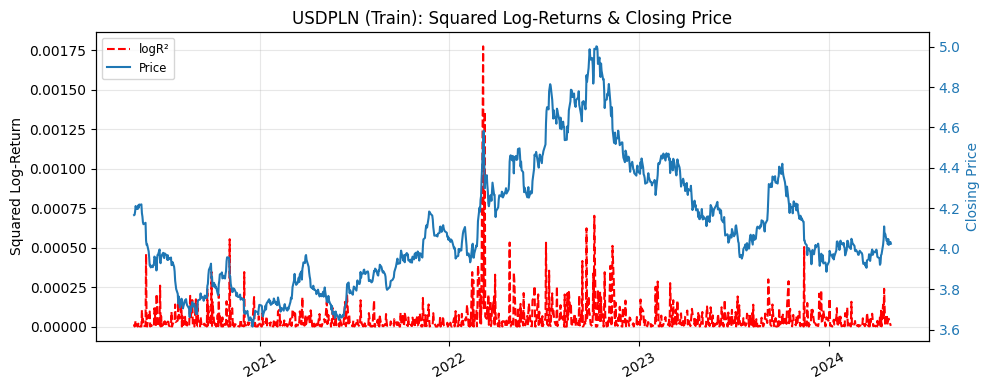

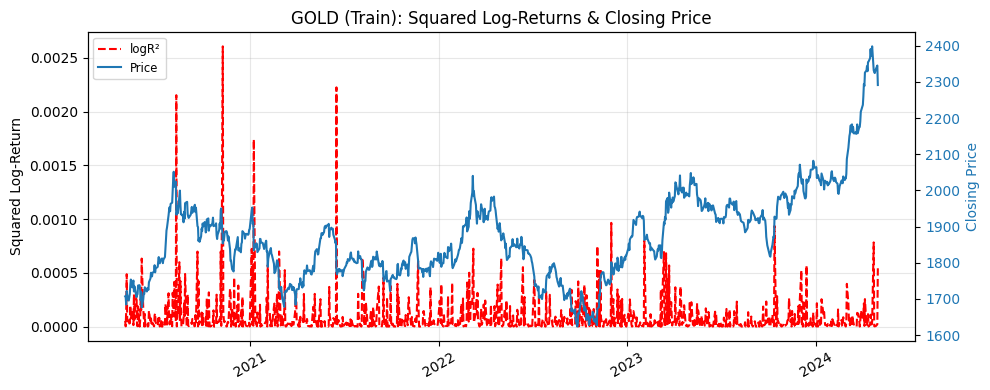

In [15]:
# Mapping of in-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

# Loop over in-sample assets
for name, df in assets_train.items():
    if 'Close' not in df.columns:
        continue

    # Prepare DataFrame
    df = df.copy()
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['Close']).diff()
    df = df.dropna(subset=['log_return'])

    # Create figure and primary axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # 1) Plot squared log‐returns (red dashed)
    ax.plot(
        df.index,
        df['log_return'] ** 2,
        linestyle='--',
        color='red',
        label="logR²"
    )
    ax.set_ylabel('Squared Log-Return')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3)

    # 2) Plot closing price on secondary axis
    ax2 = ax.twinx()
    ax2.plot(
        df.index,
        df['Close'],
        linestyle='-',
        color='#1f77b4',
        label=f'Price'
    )
    ax2.set_ylabel('Closing Price', color='#1f77b4')
    ax2.tick_params(axis='y', labelcolor='#1f77b4')

    # 3) Combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(
        h1 + h2,
        l1 + l2,
        loc='upper left',
        fontsize='small'
    )

    # Title and layout
    plt.title(f'{name.upper()} (Train): Squared Log-Returns & Closing Price')
    plt.tight_layout()
    plt.show()


In these dual‐axis charts, the solid blue line represents the daily closing price and the red dashed line shows the squared log‐returns. Squaring returns compresses small fluctuations toward zero while dramatically amplifying larger moves, making high‐volatility spikes immediately apparent. Calm phases appear as an almost flat red band beneath a smooth price curve, whereas turbulent periods—such as during financial shocks or major news events—produce clustered red peaks corresponding to substantial price swings. This clearly separates low‐volatility regimes from turbulent ones and demonstrates squared log‐returns’ effectiveness as a volatility proxy.
Indeed,these bursts of elevated squared returns, followed by stretches of near‐zero activity, are the hallmark of volatility clustering:

1. Clusters of tall red peaks correspond to sustained high‐volatility episodes, not just single shocks.

2. Flat red bands align with quieter market phases, showing volatility remaining persistently low.

Because those spikes tend to appear in runs (and not randomly), they exhibit positive autocorrelation: high volatility begets more high volatility, and low begets low. That very persistence—clearly visible in the way the red spikes bunch together on the time axis—is what ARCH/GARCH models are designed to capture.

This clustering pattern can be formally tested by examining the autocorrelation function (ACF) of the squared log-returns. Under volatility clustering, the ACF of $r_t^2$​ will display significantly positive values at multiple lags, indicating that today’s large squared return predicts tomorrow’s. In statistical terms, volatility clustering is nothing more than a strong positive autocorrelation structure in the latent variance process.

As a complementary check, one can also plot the ACF of **absolute** log‐returns $|r_{t}|$.  Although $|r_{t}|$ is a biased proxy for conditional variance, its ACF tends to be smoother and easier to read—still revealing the same long‐memory clustering in volatility without the extreme leverage of squaring. 

# 3. ARCH effects among log-returns, autocorrelation of squared returns,

## 3.1 Squared log returns - AutoCorrelation Function - ACF 

### 3.1.1 Squared log returns ACF of single indeces

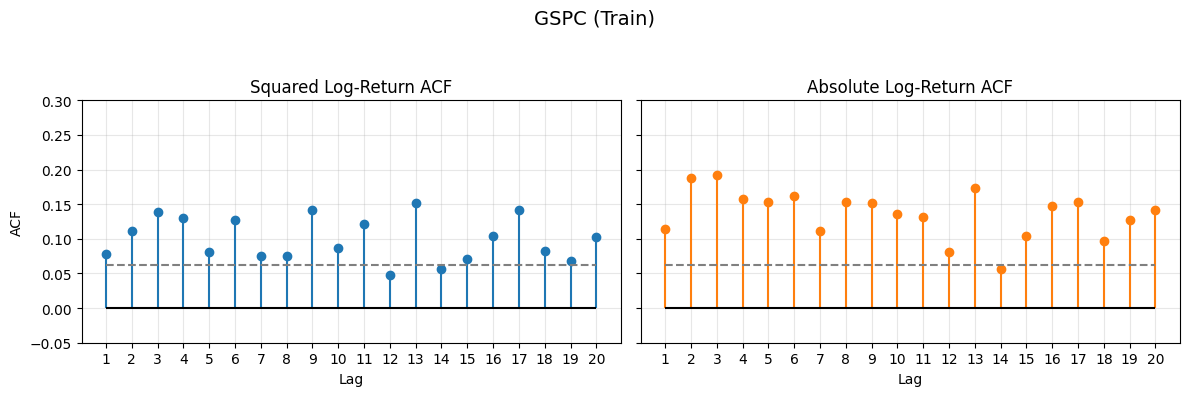

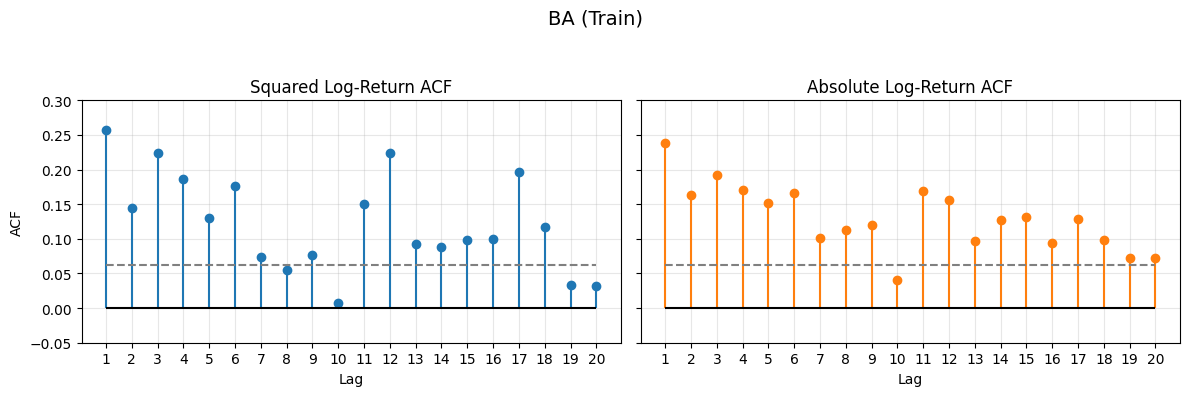

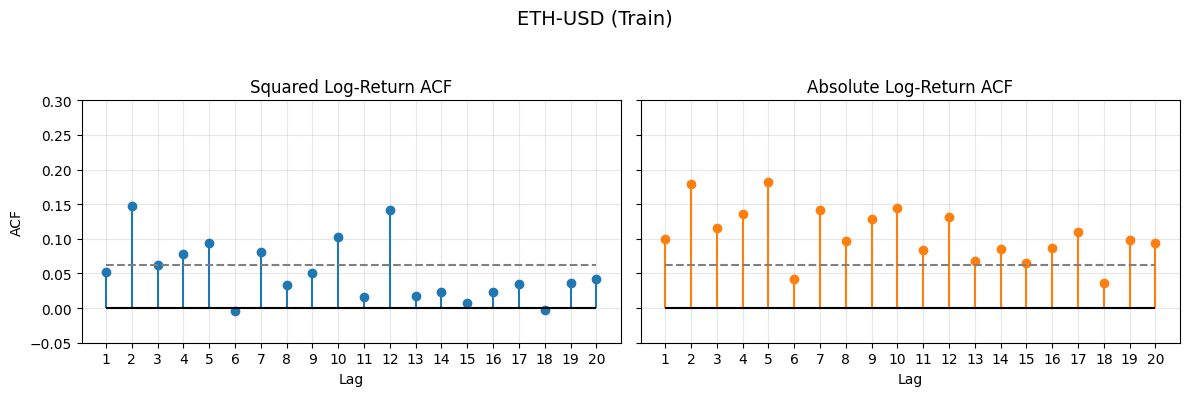

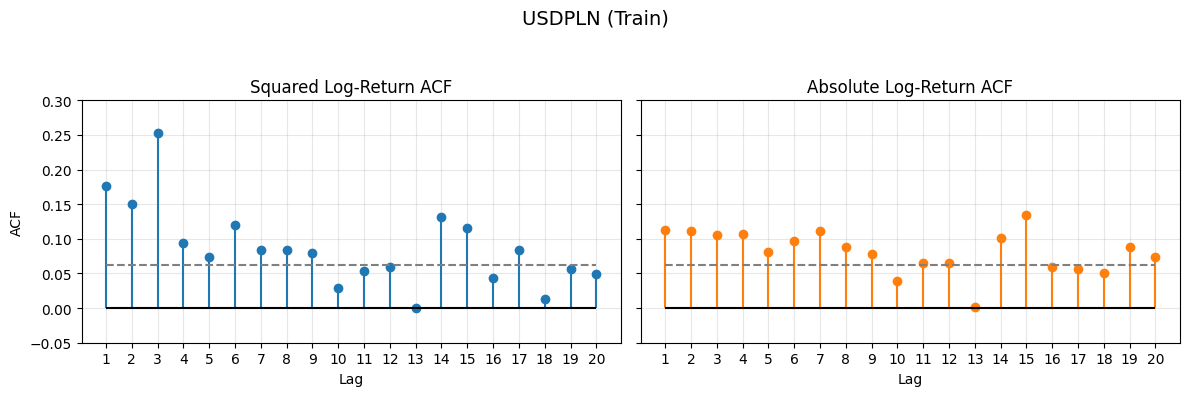

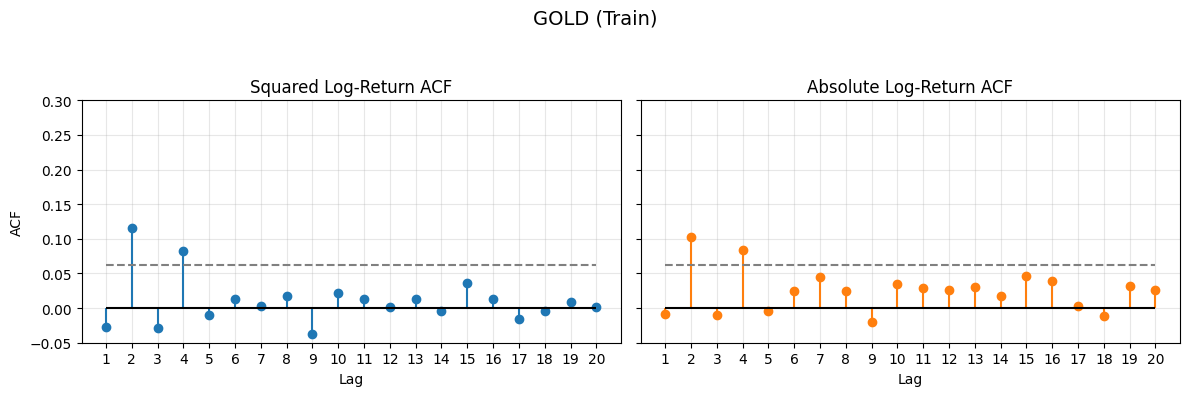

In [16]:
# In-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

nlags = 20

for name, df in assets_train.items():
    df = df.copy()
    log_ret = np.log(df['Close']).diff().dropna()
    r2 = log_ret ** 2
    r_abs = log_ret.abs()

    # ACF computation
    acf2 = acf(r2, nlags=nlags, fft=False)
    acf_abs = acf(r_abs, nlags=nlags, fft=False)
    N = len(log_ret)
    conf = 1.96 / np.sqrt(N)
    lags = np.arange(1, nlags + 1)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    fig.suptitle(f"{name.upper()} (Train)", fontsize=14)

    # Squared returns ACF
    axes[0].stem(lags, acf2[1:], linefmt='C0-', markerfmt='C0o', basefmt=' ')
    axes[0].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
    axes[0].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
    axes[0].set_title("Squared Log-Return ACF")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")
    axes[0].set_xticks(lags)
    axes[0].set_ylim(-0.05, 0.30)
    axes[0].grid(alpha=0.3)

    # Absolute returns ACF
    axes[1].stem(lags, acf_abs[1:], linefmt='C1-', markerfmt='C1o', basefmt=' ')
    axes[1].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
    axes[1].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
    axes[1].set_title("Absolute Log-Return ACF")
    axes[1].set_xlabel("Lag")
    axes[1].set_xticks(lags)
    axes[1].set_ylim(-0.05, 0.30)
    axes[1].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


### 3.1.2 ACF of entire balanced portfolio

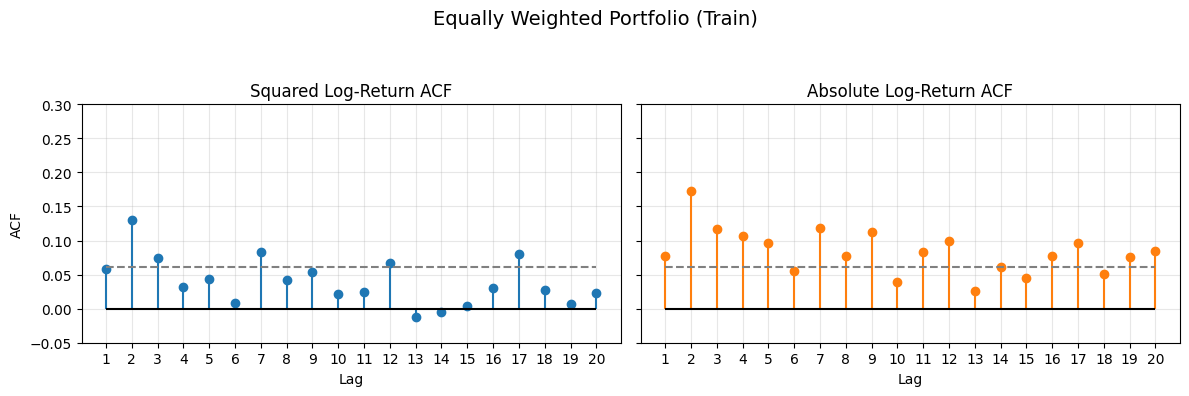

In [17]:
nlags = 20 #same  of lags

# Usa i log-return in-sample del portafoglio già calcolati
port_ret = log_return_train_df['portfolio'].dropna()

# Serie al quadrato e assoluta
r2 = port_ret**2
r_abs = port_ret.abs()

# Calcola ACF e bande di confidenza
acf2 = acf(r2, nlags=nlags, fft=False)
acf_abs = acf(r_abs, nlags=nlags, fft=False)
N = len(port_ret)
conf = 1.96 / np.sqrt(N)
lags = np.arange(1, nlags + 1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle("Equally Weighted Portfolio (Train)", fontsize=14)

# Squared log-return ACF
axes[0].stem(lags, acf2[1:], linefmt='C0-', markerfmt='C0o', basefmt=' ')
axes[0].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
axes[0].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
axes[0].set_title("Squared Log-Return ACF")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")
axes[0].set_xticks(lags)
axes[0].set_ylim(-0.05, 0.30)
axes[0].grid(alpha=0.3)

# Absolute log-return ACF
axes[1].stem(lags, acf_abs[1:], linefmt='C1-', markerfmt='C1o', basefmt=' ')
axes[1].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
axes[1].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
axes[1].set_title("Absolute Log-Return ACF")
axes[1].set_xlabel("Lag")
axes[1].set_xticks(lags)
axes[1].set_ylim(-0.05, 0.30)
axes[1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


Below each panel, focus on the height and persistence of the spikes:

* Magnitude of the bars. Taller bars at early lags mean that large squared (or absolute) returns today tend to be followed by large values tomorrow — a clear signature of volatility clustering.

* Decay pattern. If the bars decline slowly over many lags, it implies that shocks to volatility are long‐lasting. A rapid drop would suggest only very short‐lived clusters.

* Absolute vs. squared. Compare the two series: absolute returns often show even stronger, smoother autocorrelation curves, making persistence easier to spot.

* Confidence bounds. Any spike crossing the dashed horizontal lines is statistically significant. Those are the lags at which past volatility meaningfully predicts future volatility.

In practice, these features tell us that volatility is far from “white noise” — it has memory. That memory is exactly what ARCH/GARCH families exploit when they model today’s variance as a function of yesterday’s shocks (and/or its previous values). In our case

1. S&P 500 (GSPC)
 

The S&P 500 exhibits clear volatility clustering: its squared‐return ACF shows multiple significant spikes at lags 1, 3–4, 9, 13–14, 16–17 and beyond, and the absolute‐return ACF is even stronger and smoother. This persistence—shocks to volatility leaving a long “memory”—is the hallmark of an ARCH effect.

2. Boeing (BA)

Boeing’s squared‐return ACF starts extremely high at lag 1 (≈ 0.26), then decays slowly with further significant spikes at lags 3–4, 6, 9, 12 and 16. Its absolute‐return ACF mirrors this pattern. Such slow decay and high early autocorrelations point to very pronounced heteroskedasticity and strong ARCH-type dynamics.

3. Ethereum USD (ETHUSD)

Ethereum’s squared‐return ACF has pronounced peaks at lags 2, 4, 7 and 10, and remains above significance out to lag 20; the absolute‐return ACF is comparably persistent. Although slightly less “peaky” than equities, crypto returns still display robust volatility clustering, indicating that large intraday moves beget further large moves.

4. USD/PLN Exchange Rate (PLNX)

The USD/PLN pair shows moderate but significant autocorrelation in squared returns at lags 1, 3, 4 and 7–8, with a more rapid decay thereafter; the absolute‐return ACF is weaker but still above the confidence bounds at several early lags. This suggests milder heteroskedasticity than stocks or crypto, yet still a detectable ARCH effect in currency markets.

5. Gold (GCF)

Gold’s squared‐return ACF peaks mainly at lag 2, with only this lag
 crossing significance—subsequent autocorrelations hover near zero. The absolute‐return ACF likewise shows a couple of early significant bars. This pattern implies that gold volatility clusters only briefly: shocks have shorter lives, and the ARCH effect is far weaker here than in other assets.

* Equally-Weighted Portfolio

The aggregated portfolio retains clear volatility clustering in both squared and absolute returns—significant at lags 1–3, 7, 12 and 16—though peak autocorrelations are dampened relative to the most volatile components. This confirms that, even after diversification, conditional heteroskedasticity persists: today’s portfolio variance remains a strong predictor of tomorrow’s. Such findings justify the use of GARCH-family models at the portfolio level as well.











## 3.2 Testing for ARCH effects

As previously mentioned, the strong persistence we observed in the autocorrelations of squared (and absolute) returns reflects the presence of **ARCH effects**, or autoregressive conditional heteroskedasticity.  ARCH effects arise whenever current volatility depends on past squared shocks, causing variance to evolve through time rather than remain constant.  Testing for ARCH effects is therefore a crucial diagnostic step: it confirms whether a simple constant‐variance model is inadequate and whether more sophisticated volatility models are warranted.  In practice, detecting ARCH effects guides us to formally specify and estimate the correct conditional‐variance structure.  

To formally confirm the presence of ARCH effects, we apply Engle's ARCH test, which is based on the autocorrelation between squared log returns.




In [18]:
from statsmodels.stats.diagnostic import het_arch

results = {}

# Dati in-sample (train)
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

# 1) ARCH test su ogni asset in-sample
for name, df in assets_train.items():
    df = df.copy()
    log_ret = np.log(df['Close']).diff().dropna()
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(log_ret, nlags=5)
    results[name] = {
        'LM Stat': lm_stat,
        'LM p-value': lm_pvalue,
        'F Stat': f_stat,
        'F p-value': f_pvalue
    }

# 2) ARCH test sul portafoglio equally-weighted (in-sample)
# Assicurati che le colonne siano allineate per calcolo corretto
rets_train = pd.concat(
    [np.log(df['Close']).diff() for df in assets_train.values()],
    axis=1
).dropna()
rets_train.columns = list(assets_train.keys())

port_ret = rets_train.mean(axis=1)

lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(port_ret, nlags=5)
results['Portfolio'] = {
    'LM Stat': lm_stat,
    'LM p-value': lm_pvalue,
    'F Stat': f_stat,
    'F p-value': f_pvalue
}

# 3) Visualizza i risultati
for key, res in results.items():
    print(f"--- {key} ---")
    print(f"LM Statistic: {res['LM Stat']:.3f}   p-value: {res['LM p-value']:.3f}")
    print(f"F Statistic:  {res['F Stat']:.3f}   p-value: {res['F p-value']:.3f}")
    print()


--- GSPC ---
LM Statistic: 45.294   p-value: 0.000
F Statistic:  9.432   p-value: 0.000

--- BA ---
LM Statistic: 113.083   p-value: 0.000
F Statistic:  25.347   p-value: 0.000

--- ETH-USD ---
LM Statistic: 34.527   p-value: 0.000
F Statistic:  7.109   p-value: 0.000

--- USDPLN ---
LM Statistic: 90.855   p-value: 0.000
F Statistic:  19.867   p-value: 0.000

--- GOLD ---
LM Statistic: 19.710   p-value: 0.001
F Statistic:  3.997   p-value: 0.001

--- Portfolio ---
LM Statistic: 24.310   p-value: 0.000
F Statistic:  4.953   p-value: 0.000



In [19]:
# automatize the display of ARCH effects and comparsion between assets
for name, res in results.items():
    lm_pval = res['LM p-value']
    f_pval = res['F p-value']
    arch_present = "YES" if lm_pval < 0.05 or f_pval < 0.05 else "NO"

    print(f"--- {name} ---")
    print(f"ARCH Effects Present: {arch_present}")
    print()

--- GSPC ---
ARCH Effects Present: YES

--- BA ---
ARCH Effects Present: YES

--- ETH-USD ---
ARCH Effects Present: YES

--- USDPLN ---
ARCH Effects Present: YES

--- GOLD ---
ARCH Effects Present: YES

--- Portfolio ---
ARCH Effects Present: YES



The results of the LM-ARCH test (Engle's test) conducted on in-sample daily log-returns for all individual assets and the equally-weighted portfolio are reported below. The test examines whether there is significant conditional heteroskedasticity (ARCH effects) in the return series.

All p-values for both the LM and F statistics are below the conventional significance threshold of 0.05. This implies that we **reject the null hypothesis of no ARCH effects** for all series.

| Asset      | LM p-value | F p-value | ARCH Effects Present? |
|------------|------------|-----------|------------------------|
| GSPC       | 0.000      | 0.000     | YES                    |
| BA         | 0.000      | 0.000     | YES                    |
| ETH-USD    | 0.000      | 0.000     | YES                    |
| USDPLN     | 0.000      | 0.000     | YES                    |
| GOLD       | 0.001      | 0.001     | YES                    |
| Portfolio  | 0.000      | 0.000     | YES                    |

The automated test correctly flags the **presence of ARCH effects** in all series based on statistically significant results. This supports the use of GARCH-type models for volatility modeling and forecasting.


---

# MI SONO FERMATO QUI
---

## Leverage Effect (DA CAPIRE COME IMPLEMENTARE IN PYTHON LA EMPIRICAL NEWS IMPACT CURVE E/O SCATTERPLOT R^2 VS LOG RETURN LAGGATI)
Continuing from our discussion of persistence in volatility, the **leverage effect** highlights an important asymmetry in how bad news and good news impact future risk. Empirically, volatility often rises more sharply after negative returns than after positive returns of the same size. In statistical terms, this means that estimates of today’s volatility tend to be negatively correlated with yesterday’s return. 

Black (1976) and Christie (1982) tied this behavior to financial leverage: when a firm’s share price falls, its debt-to-equity ratio climbs, signaling higher risk and thus higher expected volatility. To explore the leverage effect, one can:

1. **Plot an empirical “news impact curve”** by graphing the volatility versus the lagged returns. A steeper increase on the negative-return side confirms that downward shocks amplify volatility more than upward shocks.

Capturing this asymmetric response is key to accurate volatility modeling and motivates the use of asymmetric GARCH specifications (e.g., EGARCH, GJR-GARCH) that allow negative returns to have a larger effect on future variance.


In [ ]:
# Identify assets with price data
assets = [name for name, df in data_dict.items() if 'Close' in df.columns]

# Prepare subplots: 5 rows x 1 column
fig, axes = plt.subplots(len(assets), 1, figsize=(8, 4*len(assets)), sharex=False)
fig.suptitle("Empirical News Impact Curves for All Assets", fontsize=16, y=0.92)

for ax, name in zip(axes, assets):
    df = data_dict[name].copy()
    # Compute daily log-returns and drop NaNs
    df['r'] = np.log(df['Close']).diff()
    df = df.dropna()
    
    # Volatility proxy = squared log-returns
    df['vol'] = df['r']**2
    # Lagged return
    df['r_lag1'] = df['r'].shift(1)
    df = df.dropna()
    
    x = df['r_lag1']
    y = df['vol']
    
    # LOWESS smoothing
    smoothed = lowess(y, x, frac=0.3)
    
    # Scatter + LOWESS
    ax.scatter(x, y, alpha=0.3, s=10, label='Observed')
    ax.plot(smoothed[:,0], smoothed[:,1], 'r--', linewidth=2, label='LOWESS Fit')
    
    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(f"{name.upper()}")
    ax.set_ylabel("Volatility Proxy (r²)")
    ax.legend()
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Lagged Return $r_{t-1}$")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Portfolio Volatility

In a portfolio composed of $m$ assets, the portfolio return at time $t$ is defined as a weighted average of individual asset log-returns:

$$
r_t^{(p)} = \sum_{i=1}^m w_{t,i} \, r_{t,i}
$$

where $r_{t,i}$ is the log-return of asset $i$, and $w_{t,i}$ is the portfolio weight assigned to asset $i$ at time $t$.

The conditional variance of the portfolio return—i.e., the **portfolio volatility**—is given by:

$$
v_t^{(p)} = \operatorname{Var}(r_t^{(p)} \mid \mathcal{I}_{t-1}) = \sum_{i=1}^m w_{t,i}^2 \, v_{t,ii} + \sum_{i \ne j} w_{t,i} w_{t,j} \, v_{t,ij}
$$

where $v_{t,ii}$ are the conditional variances and $v_{t,ij}$ the conditional covariances between assets $i$ and $j$.

Alternatively, this can be expressed in matrix form as:

$$
v_t^{(p)} = w_t^\top V_t w_t
$$

where:
- $w_t$ is the vector of portfolio weights $(w_{t,1}, \ldots, w_{t,m})^\top$,
- $V_t$ is the conditional variance-covariance matrix of asset returns.

Using the conditional correlation matrix $R_t$ and a diagonal matrix $D_t$ of conditional standard deviations (i.e., $D_t = \operatorname{diag}(\sqrt{v_{t,11}}, \ldots, \sqrt{v_{t,mm}})$), we can write:

$$
v_t^{(p)} = w_t^\top D_t R_t D_t w_t
$$

This formulation allows to decompose portfolio variance into standard deviations and correlations, which is particularly useful in risk modeling and optimization.


Two main approaches can be adopted:

- **Direct approach**: this method involves modeling the univariate time series of the portfolio returns directly, applying standard volatility measures such as rolling standard deviation or univariate GARCH models. This approach treats the portfolio as a single asset.

- **Indirect approach**: in contrast, this method acknowledges that portfolio volatility depends both on the individual volatilities of the assets and on their covariances (co-volatilities). The indirect approach involves estimating the conditional variances and covariances of the individual assets and combining them according to the formula $v_t^{(p)} = w_t^\top V_t w_t$. This is the more robust and theoretically sound method, especially when dealing with time-varying volatility and correlations.

Notably, only the **indirect approach** allows for portfolio optimization, such as minimizing portfolio variance subject to a target expected return. While the estimation of individual volatilities is relatively straightforward using univariate GARCH models, the estimation of dynamic covariances requires more sophisticated techniques. In the following, we will focus on this indirect approach by modeling each asset's volatility separately and then constructing the portfolio variance from the estimated components.


## Volatility Modeling of Individual Assets

In order to accurately estimate portfolio volatility using the indirect approach, we first need reliable estimates of the conditional variance of each individual asset. For this purpose, we fit volatility models from the GARCH family to each return series. Specifically, we consider three popular specifications: **GARCH** and **EGARCH**. Each of these models captures different features of financial return volatility, such as persistence, asymmetry, and leverage effects.

To determine the most appropriate model for each asset, we perform a model selection procedure based on information criteria (such as the Bayesian Information Criterion, BIC) that will be further explained.

A key modeling assumption we impose is that the conditional mean of returns is constant - and in some cases equal to zero -, i.e.,

$$
r_t = \mu_t + u_t = \mu_t + z_t h_t = z_t h_t,
$$

where $z_t$ is an i.i.d. innovation with mean zero and variance one, and $h_t$ is the conditional standard deviation. This assumption simplifies the estimation and focuses the analysis purely on the second moment dynamics, which is justified when the mean is negligible compared to the volatility or when the goal is solely to model time-varying risk.

### 📌 Model Selection and Diagnostic Validation

To select the most suitable volatility model for each asset, we implement a comprehensive grid search procedure over various GARCH-type specifications (standard GARCH, EGARCH, and GJR-GARCH), evaluating combinations of lags $(p, q)$ and, where applicable, asymmetric terms $(o)$. This process is conducted under Student's $t$ error distributions, and models are evaluated using information criteria such as the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). Although the selection process is automated to ensure consistency and efficiency, it is not sufficient on its own. For each best model identified, we conduct a thorough residual diagnostics assessment to manually confirm its adequacy.

Specifically, we analyze the **autocorrelation function (ACF)** of both the standardized residuals and their squared values to detect any remaining serial correlation or ARCH effects not captured by the model. We also perform the **Ljung-Box test** and the **ARCH LM test** to formally assess the presence of autocorrelation and heteroskedasticity, respectively. In addition, we inspect the **conditional standard deviation** $\hat{h}_t$ estimated by the model. This quantity reflects the time-varying volatility: as a diagnostic, it should respond coherently to known periods of market stress or calm (e.g., peaks in $\hat{h}_t$ during crises), and should not display implausible spikes or prolonged constancy.

For the final best model of each asset, we further validate robustness and specification by applying advanced tests including the **Nyblom Stability Test** (to assess parameter stability over time), the **Sign Bias Test** (to detect asymmetric effects not captured by the model), and the **Adjusted Pearson Goodness-of-Fit Test**, which evaluates whether the model’s residual distribution conforms to the assumed innovation process.

This dual approach — combining automated model selection with rigorous manual diagnostics — ensures that our volatility estimates are both statistically justified and economically interpretable.


In [ ]:
def fit_and_summarize(model_info, label, ticker):
    print(f"\n📈 Summary of Best {label} Model for {ticker.upper()}:")
    
    p = int(model_info["p"])
    q = int(model_info["q"])
    o = int(model_info["o"])
    model_type = model_info["Model"]

    y = 100 * log_return_df[ticker].dropna()

    if model_type == "EGARCH":
        model = arch_model(
            y, vol='EGARCH', p=p, o=o, q=q,
            mean='Zero', dist='t'
        )
    elif model_type == "GJR":
        model = arch_model(
            y, vol='GARCH', p=p, o=o, q=q,
            mean='Zero', dist='t'
        )
    else:  # GARCH
        model = arch_model(
            y, vol='GARCH', p=p, q=q,
            mean='Zero', dist='t'
        )

    result = model.fit(disp="off")
    print(result.summary())
    return result


### GSPC - Modelling

In [ ]:
from arch import arch_model
import warnings

warnings.filterwarnings("ignore")

# Parameter ranges
p_range = range(0, 4)
q_range = range(0, 4)
o_range = range(1, 2)  # Typically o = 1 is sufficient

model_types = ["GARCH", "EGARCH", "GJR"]
results = []

# Grid Search with conditional 'o'
for model_type in model_types:
    for p in p_range:
        for q in q_range:
            if model_type in ["EGARCH", "GJR"]:
                for o in o_range:
                    try:
                        am = arch_model(
                            100 * log_return_df["gspc"].dropna(),
                            vol=model_type,
                            mean='Zero',
                            dist='t',
                            p=p,
                            o=o,
                            q=q
                        )
                        res = am.fit(disp='off')
                        results.append({
                            "Model": model_type,
                            "p": p,
                            "o": o,
                            "q": q,
                            "AIC": res.aic,
                            "BIC": res.bic,
                            "LogLik": res.loglikelihood
                        })
                    except Exception:
                        continue
            else:  # Standard GARCH
                try:
                    am = arch_model(
                        100 * log_return_df["gspc"].dropna(),
                        vol=model_type,
                        mean='Zero',
                        dist='t',
                        p=p,
                        q=q
                    )
                    res = am.fit(disp='off')
                    results.append({
                        "Model": model_type,
                        "p": p,
                        "o": 0,
                        "q": q,
                        "AIC": res.aic,
                        "BIC": res.bic,
                        "LogLik": res.loglikelihood
                    })
                except Exception:
                    continue

# Result DataFrame
result_df = pd.DataFrame(results)

# Best by AIC and BIC
best_aic = result_df.loc[result_df["AIC"].idxmin()]
best_bic = result_df.loc[result_df["BIC"].idxmin()]

# Display
print("✅ Best model by AIC:")
print(best_aic)
print("\n✅ Best model by BIC:")
print(best_bic)

best_model_gspc_bic_result = fit_and_summarize(best_bic, "BIC", "gspc")





The best fitting model for the log-returns of the S&P 500 index (GSPC) according to both AIC and BIC criteria is an **EGARCH(1,1)** model with one asymmetric term. The Exponential GARCH model captures potential leverage effects and allows for an asymmetric response of volatility to positive and negative shocks. The specification of the EGARCH(1,1) model is given by:

$$
INSERIRE SPECIFICAZIONE MODELLO 
$$

where:
- $h_t$ is the conditional variance at time $t$,
- $\varepsilon_t$ are the residuals (innovations),
- $\omega$ is a constant,
- $\alpha$ captures the symmetric shock effect,
- $\gamma$ models the asymmetric effect (e.g., leverage),
- $\beta$ captures persistence in volatility.

The inclusion of the $\gamma$ parameter allows the model to account for the empirical observation that negative returns tend to increase volatility more than positive returns of the same magnitude.

The estimated EGARCH(1,1) model for the S&P 500 log-returns reveals a highly persistent volatility process, with a significant and near-unit β coefficient, confirming long memory in conditional variance. The γ parameter is significantly negative, indicating a clear leverage effect, where negative shocks have a stronger impact on volatility than positive ones of the same magnitude. The α coefficient, which captures the symmetric response to shocks, is not statistically significant—suggesting that volatility reacts more to the direction of shocks than to their absolute size. This is a common finding in financial time series and supports the use of asymmetric models like EGARCH. The estimated degrees of freedom of the t-distribution further confirm the presence of fat tails in return innovations.








In [ ]:


# Calcolo residui standardizzati
std_resid_gspc = best_model_gspc_bic_result.std_resid

# Crea figura con 2 subplot affiancati
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

# Plot ACF dei residui standardizzati
plot_acf(std_resid_gspc[1:], lags=35, ax=axs[0])
axs[0].set_ylim(-0.2, 0.2)
axs[0].set_title("ACF of Standardized Residuals")
axs[0].grid(True)

# Plot ACF dei residui standardizzati al quadrato
plot_acf(std_resid_gspc[1:]**2, lags=20, ax=axs[1])
axs[1].set_ylim(-0.2, 0.2)
axs[1].set_title("ACF of Squared Standardized Residuals")
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Definisci i lag da testare
lags = [5, 10, 15, 20]

# Ljung-Box test sui residui standardizzati
lb_test_std = acorr_ljungbox(std_resid_gspc, lags=lags, return_df=True)

# Ljung-Box test sui residui standardizzati al quadrato
lb_test_std_sq = acorr_ljungbox(std_resid_gspc**2, lags=lags, return_df=True)

# Visualizza i risultati
print("📊 Ljung-Box on standardized residuals:")
print(lb_test_std)

print("\n📊 Ljung-Box on squared standardized residuals:")
print(lb_test_std_sq)

# ARCH LM test 
arch_test_stat, arch_test_pvalue, _, _ = het_arch(std_resid_gspc.dropna(), nlags=35)

# Output dei risultati
print("📊 ARCH Test on Standardized Residuals:")
print(f"F-statistic: {arch_test_stat:.4f}")
print(f"p-value:     {arch_test_pvalue:.4f}")



The Ljung-Box test applied to standardized residuals shows no evidence of autocorrelation up to lag 5 (p = 0.21), but becomes significant from lag 10 onward (e.g., p = 0.01898 at lag 10, and p = 0.00621 at lag 20). This suggests that some linear dependence remains in the conditional mean, which could be addressed by incorporating a richer mean specification, although the autoregressive term in the mean was previously found to be statistically insignificant.

In contrast, the Ljung-Box test on squared standardized residuals reports p-values consistently above 0.35 at all lags, and the ARCH test returns a high p-value (0.9681). These results confirm the absence of remaining ARCH effects and indicate that the model has successfully captured the heteroskedastic nature of the data. Furthermore, the ACF plots reinforce this conclusion, with the squared residuals lying well within the confidence bands, showing no persistent autocorrelation in conditional variance.

In conclusion, despite minor misspecification in the mean, the model is well-suited for volatility forecasting and risk metrics such as Value-at-Risk, as the variance structure is adequately modeled and residual volatility is effectively neutralized.

### Boeing (BA)

In [ ]:
from arch import arch_model
import warnings

warnings.filterwarnings("ignore")

# Parameter ranges
p_range = range(0, 4)
q_range = range(0, 4)
o_range = range(1, 2)  # Typically o = 1 is sufficient

model_types = ["GARCH", "EGARCH", "GJR"]
results = []

# Grid Search with conditional 'o'
for model_type in model_types:
    for p in p_range:
        for q in q_range:
            if model_type in ["EGARCH", "GJR"]:
                for o in o_range:
                    try:
                        am = arch_model(
                            100 * log_return_df["ba"].dropna(),
                            vol=model_type,
                            mean='Zero',
                            dist='t',
                            p=p,
                            o=o,
                            q=q
                        )
                        res = am.fit(disp='off')
                        results.append({
                            "Model": model_type,
                            "p": p,
                            "o": o,
                            "q": q,
                            "AIC": res.aic,
                            "BIC": res.bic,
                            "LogLik": res.loglikelihood
                        })
                    except Exception:
                        continue
            else:  # Standard GARCH
                try:
                    am = arch_model(
                        100 * log_return_df["ba"].dropna(),
                        vol=model_type,
                        mean='Zero',
                        dist='t',
                        p=p,
                        q=q
                    )
                    res = am.fit(disp='off')
                    results.append({
                        "Model": model_type,
                        "p": p,
                        "o": 0,
                        "q": q,
                        "AIC": res.aic,
                        "BIC": res.bic,
                        "LogLik": res.loglikelihood
                    })
                except Exception:
                    continue

# Result DataFrame
result_df = pd.DataFrame(results)

# Best by AIC and BIC
best_aic = result_df.loc[result_df["AIC"].idxmin()]
best_bic = result_df.loc[result_df["BIC"].idxmin()]

# Display
print("✅ Best model by AIC:")
print(best_aic)
print("\n✅ Best model by BIC:")
print(best_bic)

best_model_ba_bic_result = fit_and_summarize(best_bic, "BIC", "ba")
best_model_ba_aic_result = fit_and_summarize(best_aic, "AIC", "ba")




For Boeing, model selection led to diverging outcomes depending on the information criterion used. The AIC selected an EGARCH(1,1,2) model, indicating a better in-sample fit despite increased complexity, while the BIC favored the simpler GARCH(1,1), prioritizing parsimony. This divergence is not uncommon and reflects the different penalty structures of the two criteria. Given that our focus is on accurately capturing volatility dynamics—particularly asymmetries and persistence—the EGARCH model may be more appropriate, though the GARCH(1,1) remains a valid benchmark for robustness and comparison; let's explore the diagnostic tools for both models.


In [ ]:
# Calcolo residui standardizzati
std_resid_aic_ba = best_model_ba_aic_result.std_resid
std_resid_bic_ba = best_model_ba_bic_result.std_resid

# Crea figura con 4 subplot (2x2)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

# ACF residui standardizzati - BIC
plot_acf(std_resid_bic_ba, lags=35, ax=axs[0, 0])
axs[0, 0].set_ylim(-0.2, 0.2)
axs[0, 0].set_title("GARCH(1;1): ACF of Standardized Residuals")
axs[0, 0].grid(True)

# ACF residui standardizzati al quadrato - BIC
plot_acf(std_resid_bic_ba**2, lags=20, ax=axs[0, 1])
axs[0, 1].set_ylim(-0.2, 0.2)
axs[0, 1].set_title("GARCH(1;1): ACF of Squared Standardized Residuals")
axs[0, 1].grid(True)

# ACF residui standardizzati - AIC
plot_acf(std_resid_aic_ba, lags=35, ax=axs[1, 0])
axs[1, 0].set_ylim(-0.2, 0.2)
axs[1, 0].set_title("EGARCH(1;2): ACF of Standardized Residuals")
axs[1, 0].grid(True)

# ACF residui standardizzati al quadrato - AIC
plot_acf(std_resid_aic_ba**2, lags=20, ax=axs[1, 1])
axs[1, 1].set_ylim(-0.2, 0.2)
axs[1, 1].set_title("EGARCH(1;2): ACF of Squared Standardized Residuals")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()



The GARCH(1;1) model seems better if we look at the ACF of standardized squared residuals; let's take a look at the LB and ARCH test:

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Standardized residuals from both models
std_resid_egarch = best_model_ba_aic_result.std_resid
std_resid_garch = best_model_ba_bic_result.std_resid

# === Ljung-Box Test on Standardized Residuals ===
print("📊 Ljung-Box Test on Standardized Residuals - EGARCH(1,2):")
for lag in [5, 10, 15, 20]:
    lb = acorr_ljungbox(std_resid_egarch.dropna(), lags=[lag], return_df=True)
    print(f"Lag {lag}: LB stat = {lb['lb_stat'].values[0]:.5f}, p-value = {lb['lb_pvalue'].values[0]:.5f}")

print("\n📊 Ljung-Box Test on Standardized Residuals - GARCH(1,1):")
for lag in [5, 10, 15, 20]:
    lb = acorr_ljungbox(std_resid_garch.dropna(), lags=[lag], return_df=True)
    print(f"Lag {lag}: LB stat = {lb['lb_stat'].values[0]:.5f}, p-value = {lb['lb_pvalue'].values[0]:.5f}")

# === Ljung-Box Test on Squared Standardized Residuals ===
print("\n📊 Ljung-Box Test on Squared Standardized Residuals - EGARCH(1,2):")
for lag in [5, 10, 15, 20]:
    lb = acorr_ljungbox(std_resid_egarch.dropna()**2, lags=[lag], return_df=True)
    print(f"Lag {lag}: LB stat = {lb['lb_stat'].values[0]:.5f}, p-value = {lb['lb_pvalue'].values[0]:.5f}")

print("\n📊 Ljung-Box Test on Squared Standardized Residuals - GARCH(1,1):")
for lag in [5, 10, 15, 20]:
    lb = acorr_ljungbox(std_resid_garch.dropna()**2, lags=[lag], return_df=True)
    print(f"Lag {lag}: LB stat = {lb['lb_stat'].values[0]:.5f}, p-value = {lb['lb_pvalue'].values[0]:.5f}")

# === ARCH Test on Standardized Residuals ===
print("\n📊 ARCH Test on Standardized Residuals - EGARCH(1,2):")
arch_test_egarch = het_arch(std_resid_egarch.dropna())
print(f"F-statistic: {arch_test_egarch[0]:.4f}, p-value: {arch_test_egarch[1]:.4f}")

print("\n📊 ARCH Test on Standardized Residuals - GARCH(1,1):")
arch_test_garch = het_arch(std_resid_garch.dropna())
print(f"F-statistic: {arch_test_garch[0]:.4f}, p-value: {arch_test_garch[1]:.4f}")


The Ljung-Box test results on the standardized residuals indicate that both models—EGARCH(1,2) and GARCH(1,1)—adequately capture the linear dependence in the return series. For all tested lags (5, 10, 15, 20), the p-values are comfortably above conventional significance levels (e.g., 5%), suggesting no significant residual autocorrelation in either model.

When considering the squared standardized residuals, which test for remaining ARCH effects, the results are again favorable. While the EGARCH(1,2) shows slightly lower p-values (e.g., p = 0.1307 at lag 5), they remain nonsignificant, indicating that the model has largely captured the conditional heteroskedasticity. The GARCH(1,1), in contrast, yields even higher p-values, suggesting a more thorough elimination of remaining ARCH effects—though possibly at the cost of ignoring asymmetries in volatility dynamics.

Finally, the ARCH LM test confirms these insights. For both models, the null hypothesis of no ARCH effects in the residuals cannot be rejected (p = 0.2497 for EGARCH, p = 0.7318 for GARCH), supporting the adequacy of both models in capturing second-order dependence. However, the EGARCH(1,2) remains preferable if the asymmetry or leverage effect is theoretically relevant, as it accounts for sign-dependent shock impacts.

In conclusion, both models appear statistically well-specified, with GARCH(1,1) being slightly more parsimonious, and that's why we will choose the latter.

### ETH

In [ ]:
warnings.filterwarnings("ignore")

# Parameter ranges
p_range = range(0, 4)
q_range = range(0, 4)
o_range = range(1, 2)  # Typically o = 1 is sufficient

model_types = ["GARCH", "EGARCH", "GJR"]
results = []

# Grid Search with conditional 'o'
for model_type in model_types:
    for p in p_range:
        for q in q_range:
            if model_type in ["EGARCH", "GJR"]:
                for o in o_range:
                    try:
                        am = arch_model(
                            100 * log_return_df["ethusd"].dropna(),
                            vol=model_type,
                            mean='Zero',
                            dist='t',
                            p=p,
                            o=o,
                            q=q
                        )
                        res = am.fit(disp='off')
                        results.append({
                            "Model": model_type,
                            "p": p,
                            "o": o,
                            "q": q,
                            "AIC": res.aic,
                            "BIC": res.bic,
                            "LogLik": res.loglikelihood
                        })
                    except Exception:
                        continue
            else:  # Standard GARCH
                try:
                    am = arch_model(
                        100 * log_return_df["ethusd"].dropna(),
                        vol=model_type,
                        mean='Zero',
                        dist='t',
                        p=p,
                        q=q
                    )
                    res = am.fit(disp='off')
                    results.append({
                        "Model": model_type,
                        "p": p,
                        "o": 0,
                        "q": q,
                        "AIC": res.aic,
                        "BIC": res.bic,
                        "LogLik": res.loglikelihood
                    })
                except Exception:
                    continue

# Result DataFrame
result_df = pd.DataFrame(results)

# Best by AIC and BIC
best_aic = result_df.loc[result_df["AIC"].idxmin()]
best_bic = result_df.loc[result_df["BIC"].idxmin()]

# Display
print("✅ Best model by AIC:")
print(best_aic)
print("\n✅ Best model by BIC:")
print(best_bic)


# Refit and show both summaries
best_model_ethusd_bic_result = fit_and_summarize(best_bic, "BIC", 'ethusd')



The EGARCH(1,1,1) model initially selected for Ethereum includes an asymmetric component (γ) intended to capture leverage effects in volatility. However, the estimated γ coefficient is not statistically significant, suggesting that volatility does not respond asymmetrically to positive and negative shocks. In light of this, a simpler GARCH(1,1) model—without asymmetry—may be more appropriate, as it provides a parsimonious specification without compromising model adequacy.

In [ ]:
eth_garch11 = arch_model(y = 100 * log_return_df["ethusd"], mean = "Zero", vol = "GARCH", p=1, q=1, dist = "t")

eth_garch11_result = eth_garch11.fit(disp='off')

In [ ]:
print(eth_garch11_result)

AGGIUNGERE COMMENTO :)

In [ ]:


# === Compute standardized residuals ===
std_resid_eth = eth_garch11_result.std_resid
# === ACF plots ===
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# ACF of standardized residuals
plot_acf(std_resid_eth, lags=35, ax=axs[0])
axs[0].set_title("ACF of Standardized Residuals")
axs[0].set_ylim(-0.2, 0.2)
axs[0].grid(True)

# ACF of squared standardized residuals
plot_acf(std_resid_eth**2, lags=20, ax=axs[1])
axs[1].set_title("ACF of Squared Standardized Residuals")
axs[1].set_ylim(-0.2, 0.2)
axs[1].grid(True)

plt.tight_layout()
plt.show()
# === Ljung-Box test on standardized residuals ===
print("📊 Ljung-Box Test on Standardized Residuals - GARCH(1,1):")
for lag in [5, 10, 15, 20]:
    lb_test = acorr_ljungbox(std_resid_eth, lags=[lag], return_df=True)
    lb_stat = lb_test["lb_stat"].values[0]
    lb_pval = lb_test["lb_pvalue"].values[0]
    print(f"Lag {lag}: LB stat = {lb_stat:.5f}, p-value = {lb_pval:.5f}")

# === Ljung-Box test on squared standardized residuals ===
print("\n📊 Ljung-Box Test on Squared Standardized Residuals - GARCH(1,1):")
for lag in [5, 10, 15, 20]:
    lb_test_sq = acorr_ljungbox(std_resid_eth**2, lags=[lag], return_df=True)
    lb_stat = lb_test_sq["lb_stat"].values[0]
    lb_pval = lb_test_sq["lb_pvalue"].values[0]
    print(f"Lag {lag}: LB stat = {lb_stat:.5f}, p-value = {lb_pval:.5f}")

# === ARCH Test ===
arch_test = het_arch(std_resid_eth)
print("\n📊 ARCH Test on Standardized Residuals - GARCH(1,1):")
print(f"F-statistic: {arch_test[0]:.4f}")
print(f"p-value:     {arch_test[1]:.4f}")




The diagnostic tests and ACF plots indicate that the GARCH(1,1) model fitted to Ethereum log-returns performs excellently in capturing both linear and volatility clustering effects. The Ljung-Box test on standardized residuals yields extremely high p-values across all lags (e.g., p = 0.969 at lag 5), confirming the absence of significant autocorrelation in the residuals—i.e., the conditional mean dynamics have been adequately modeled.

Similarly, the Ljung-Box test on squared standardized residuals shows no evidence of remaining ARCH effects, with p-values well above conventional thresholds (e.g., p = 0.40 to p = 0.68 across lags). These findings are further supported by the ARCH LM test, which yields a high p-value (p = 0.5883), reinforcing that the GARCH(1,1) model successfully captures conditional heteroskedasticity in the return series.

The ACF plots of both standardized and squared standardized residuals visually confirm these conclusions, with no significant spikes exceeding the confidence bounds. Overall, the model appears statistically well-specified and robust

### USDPLN


In [ ]:
warnings.filterwarnings("ignore")

# Parameter ranges
p_range = range(0, 4)
q_range = range(0, 4)
o_range = range(1, 2)  # Typically o = 1 is sufficient

model_types = ["GARCH", "EGARCH", "GJR"]
results = []

# Grid Search with conditional 'o'
for model_type in model_types:
    for p in p_range:
        for q in q_range:
            if model_type in ["EGARCH", "GJR"]:
                for o in o_range:
                    try:
                        am = arch_model(
                            100 * log_return_df["plnx"].dropna(),
                            vol=model_type,
                            mean='Zero',
                            dist='t',
                            p=p,
                            o=o,
                            q=q
                        )
                        res = am.fit(disp='off')
                        results.append({
                            "Model": model_type,
                            "p": p,
                            "o": o,
                            "q": q,
                            "AIC": res.aic,
                            "BIC": res.bic,
                            "LogLik": res.loglikelihood
                        })
                    except Exception:
                        continue
            else:  # Standard GARCH
                try:
                    am = arch_model(
                        100 * log_return_df["plnx"].dropna(),
                        vol=model_type,
                        mean='Zero',
                        dist='t',
                        p=p,
                        q=q
                    )
                    res = am.fit(disp='off')
                    results.append({
                        "Model": model_type,
                        "p": p,
                        "o": 0,
                        "q": q,
                        "AIC": res.aic,
                        "BIC": res.bic,
                        "LogLik": res.loglikelihood
                    })
                except Exception:
                    continue

# Result DataFrame
result_df = pd.DataFrame(results)

# Best by AIC and BIC
best_aic = result_df.loc[result_df["AIC"].idxmin()]
best_bic = result_df.loc[result_df["BIC"].idxmin()]

# Display
print("✅ Best model by AIC:")
print(best_aic)
print("\n✅ Best model by BIC:")
print(best_bic)


# Refit and show both summaries
best_model_plnx_bic_result = fit_and_summarize(best_bic, "BIC", "plnx")





In the volatility equation, the β coefficient (0.916, p < 0.001) is highly significant, indicating strong persistence in volatility, a common characteristic in financial time series. The α coefficient (0.054) and the intercept ω (0.0157) are not statistically significant (p = 0.217 and p = 0.519, respectively), although their signs and magnitudes are consistent with a well-behaved GARCH process. The dominance of the β parameter suggests that current volatility is mostly explained by past conditional variances, rather than recent shocks.

The degrees of freedom parameter 
𝜈
ν for the Student's t-distribution is significantly estimated (p < 0.001), confirming the presence of fat tails and justifying the use of a heavy-tailed distribution to model return innovations.

In summary, despite some coefficients not being individually significant, the model exhibits strong volatility persistence and an appropriate distributional fit. It remains a reasonable specification for capturing the risk dynamics

In [ ]:
# === Standardized residuals ===
std_resid_plnx = best_model_plnx_bic_result.std_resid

# === ACF Plots ===
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# ACF of standardized residuals
plot_acf(std_resid_plnx, lags=35, ax=axs[0])
axs[0].set_title("ACF of Standardized Residuals")
axs[0].set_ylim(-0.2, 0.2)
axs[0].grid(True)

# ACF of squared standardized residuals
plot_acf(std_resid_plnx**2, lags=20, ax=axs[1])
axs[1].set_title("ACF of Squared Standardized Residuals")
axs[1].set_ylim(-0.2, 0.2)
axs[1].grid(True)

plt.tight_layout()
plt.show()


# === Ljung-Box Test on Standardized Residuals ===
print("📊 Ljung-Box Test on Standardized Residuals - GARCH(1,1):")
for lag in [5, 10, 15, 20]:
    lb_test = acorr_ljungbox(std_resid_plnx, lags=[lag], return_df=True)
    print(f"Lag {lag}: LB stat = {lb_test['lb_stat'].values[0]:.5f}, p-value = {lb_test['lb_pvalue'].values[0]:.5f}")

# === Ljung-Box Test on Squared Standardized Residuals ===
print("\n📊 Ljung-Box Test on Squared Standardized Residuals - GARCH(1,1):")
for lag in [5, 10, 15, 20]:
    lb_test_sq = acorr_ljungbox(std_resid_plnx**2, lags=[lag], return_df=True)
    print(f"Lag {lag}: LB stat = {lb_test_sq['lb_stat'].values[0]:.5f}, p-value = {lb_test_sq['lb_pvalue'].values[0]:.5f}")

# === ARCH Test on Standardized Residuals ===
arch_test = het_arch(std_resid_plnx.dropna())
print("\n📊 ARCH Test on Standardized Residuals:")
print(f"F-statistic: {arch_test[0]:.4f}")
print(f"p-value:     {arch_test[1]:.4f}")



The model adequately captures the volatility dynamics without leaving significant serial correlation or heteroskedasticity in the residuals. The Ljung-Box test on standardized residuals shows high p-values across all lags tested (e.g., p = 0.34 at lag 5 and p = 0.75 at lag 20), suggesting no evidence of autocorrelation and confirming that the constant mean specification is appropriate for modeling the return process of this exchange rate.

Furthermore, the Ljung-Box test on squared standardized residuals supports the conclusion that the GARCH model has successfully accounted for conditional heteroskedasticity, with all p-values comfortably above conventional significance levels (e.g., p = 0.58 to p = 0.87). This is corroborated by the ARCH LM test, which yields a non-significant result (F-statistic = 7.97, p-value = 0.63), further confirming that no additional ARCH effects remain in the residuals.

### Gold

In [ ]:
warnings.filterwarnings("ignore")

# Parameter ranges
p_range = range(0, 4)
q_range = range(0, 4)
o_range = range(1, 2)  # Typically o = 1 is sufficient

model_types = ["GARCH", "EGARCH", "GJR"]
results = []

# Grid Search with conditional 'o'
for model_type in model_types:
    for p in p_range:
        for q in q_range:
            if model_type in ["EGARCH", "GJR"]:
                for o in o_range:
                    try:
                        am = arch_model(
                            100 * log_return_df["gcf"].dropna(),
                            vol=model_type,
                            mean='Zero',
                            dist='t',
                            p=p,
                            o=o,
                            q=q
                        )
                        res = am.fit(disp='off')
                        results.append({
                            "Model": model_type,
                            "p": p,
                            "o": o,
                            "q": q,
                            "AIC": res.aic,
                            "BIC": res.bic,
                            "LogLik": res.loglikelihood
                        })
                    except Exception:
                        continue
            else:  # Standard GARCH
                try:
                    am = arch_model(
                        100 * log_return_df["gcf"].dropna(),
                        vol=model_type,
                        mean='Zero',
                        dist='t',
                        p=p,
                        q=q
                    )
                    res = am.fit(disp='off')
                    results.append({
                        "Model": model_type,
                        "p": p,
                        "o": 0,
                        "q": q,
                        "AIC": res.aic,
                        "BIC": res.bic,
                        "LogLik": res.loglikelihood
                    })
                except Exception:
                    continue

# Result DataFrame
result_df = pd.DataFrame(results)

# Best by AIC and BIC
best_aic = result_df.loc[result_df["AIC"].idxmin()]
best_bic = result_df.loc[result_df["BIC"].idxmin()]

# Display
print("✅ Best model by AIC:")
print(best_aic)
print("\n✅ Best model by BIC:")
print(best_bic)


# Refit and show both summaries
best_model_gcf_bic_result = fit_and_summarize(best_bic, "BIC", "gcf")
best_model_gcf_aic_result = fit_and_summarize(best_aic, "AIC", "gcf")





For the sake of simplicity, we will also try to fit a GARCH(1;1) model and compare the diagnostics.

In [ ]:
gold_garch11 = arch_model(y = 100 * log_return_df["gcf"], mean = "Constant", vol = "GARCH", p = 1, q = 1, dist = 't')
gold_garch11_result = gold_garch11.fit()

In [ ]:
print(gold_garch11_result.summary())

In [ ]:
# Standardized residuals
std_resid_bic_gcf = best_model_gcf_bic_result.std_resid      # EGARCH(0,1)
std_resid_aic_gcf = best_model_gcf_aic_result.std_resid      # EGARCH(1,1)
std_resid_garch_gcf = gold_garch11_result.std_resid          # GARCH(1,1)

# Create 3x2 subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

# --- EGARCH(0,1) ---
plot_acf(std_resid_bic_gcf[1:], lags=35, ax=axs[0, 0])
axs[0, 0].set_ylim(-0.2, 0.2)
axs[0, 0].set_title("EGARCH(0,1): ACF of Standardized Residuals")
axs[0, 0].grid(True)

plot_acf(std_resid_bic_gcf[1:]**2, lags=20, ax=axs[0, 1])
axs[0, 1].set_ylim(-0.2, 0.2)
axs[0, 1].set_title("EGARCH(0,1): ACF of Squared Standardized Residuals")
axs[0, 1].grid(True)

# --- EGARCH(1,1) ---
plot_acf(std_resid_aic_gcf[1:], lags=35, ax=axs[1, 0])
axs[1, 0].set_ylim(-0.2, 0.2)
axs[1, 0].set_title("EGARCH(1,1): ACF of Standardized Residuals")
axs[1, 0].grid(True)

plot_acf(std_resid_aic_gcf[1:]**2, lags=20, ax=axs[1, 1])
axs[1, 1].set_ylim(-0.2, 0.2)
axs[1, 1].set_title("EGARCH(1,1): ACF of Squared Standardized Residuals")
axs[1, 1].grid(True)

# --- GARCH(1,1) ---
plot_acf(std_resid_garch_gcf[1:], lags=35, ax=axs[2, 0])
axs[2, 0].set_ylim(-0.2, 0.2)
axs[2, 0].set_title("GARCH(1,1): ACF of Standardized Residuals")
axs[2, 0].grid(True)

plot_acf(std_resid_garch_gcf[1:]**2, lags=20, ax=axs[2, 1])
axs[2, 1].set_ylim(-0.2, 0.2)
axs[2, 1].set_title("GARCH(1,1): ACF of Squared Standardized Residuals")
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()




Despite the slightly better fit of asymmetric models such as EGARCH, diagnostic plots and statistical tests did not indicate substantial improvement over the symmetric GARCH(1,1). Given its parsimony, stability, and interpretability, we opted to proceed with the GARCH(1,1) specification for modeling the conditional variance of the gold returns.

In [ ]:
lags = [5, 10, 15, 20]

# Create a dictionary of model results
models = {
    "EGARCH(0,1)": best_model_gcf_bic_result,
    "EGARCH(1,1)": best_model_gcf_aic_result,
    "GARCH(1,1)": gold_garch11_result
}

for name, result in models.items():
    print(f"\n📊 Ljung-Box Test on Standardized Residuals - {name}:")
    std_resid = result.std_resid
    lb_test = acorr_ljungbox(std_resid, lags=lags, return_df=True)
    for lag in lags:
        print(f"Lag {lag}: LB stat = {lb_test.loc[lag, 'lb_stat']:.5f}, p-value = {lb_test.loc[lag, 'lb_pvalue']:.5f}")

    print(f"\n📊 Ljung-Box Test on Squared Standardized Residuals - {name}:")
    lb_test_sq = acorr_ljungbox(std_resid**2, lags=lags, return_df=True)
    for lag in lags:
        print(f"Lag {lag}: LB stat = {lb_test_sq.loc[lag, 'lb_stat']:.5f}, p-value = {lb_test_sq.loc[lag, 'lb_pvalue']:.5f}")

    print(f"\n📊 ARCH Test on Standardized Residuals - {name}:")
    arch_test = het_arch(std_resid)
    print(f"F-statistic: {arch_test[0]:.4f}")
    print(f"p-value:     {arch_test[1]:.4f}")


DECIDERE SE PRENDERE GARCH(1;1) OPPURE EGARCH(1:1) e daje e top

---

# **Automated GARCH** Model Selection - PARTE DI GIACOMO
## How It Works

This routine automates the process of selecting the best GARCH(p,q) model for a given asset by evaluating several candidate specifications and validating their diagnostics. 

The evaluation metrics used in this automated GARCH model selection—AIC, Ljung–Box tests, and LM ARCH test—are **directly aligned with the criteria explicitly required in the project assignment**. The project instructions specify that model adequacy must be supported by:

- Absence of residual autocorrelation (checked via Ljung–Box on residuals and squared residuals),
- Absence of remaining ARCH effects (verified using the LM ARCH test),
- A well-behaved conditional volatility process.

Therefore, this procedure fully complies with the methodological standards outlined in the assignment brief.

### Step-by-Step Procedure

1. **Model Candidates**  
   The algorithm tests multiple GARCH specifications: (1,1), (2,1), (1,2), and (2,2).  
   Log-returns are rescaled by multiplying by 100 to improve numerical stability during optimization.

2. **Model Estimation**  
   For each $(p,q)$ configuration:
   - A GARCH model is estimated via maximum likelihood.
   - Standardized residuals and squared standardized residuals are extracted.

3. **Model Evaluation Criteria**

#### 1. AIC – Akaike Information Criterion  
Used directly to identify the best model balancing fit and simplicity.  
Formula:  
$$
\text{AIC} = 2k - 2\ln(\hat{L})
$$  
Where $k$ is the number of estimated parameters, and $\hat{L}$ is the maximum likelihood.  
**Lower AIC is better.**

#### 2. BIC – Bayesian Information Criterion  
Also computed for reference but not used for selection.  
It penalizes model complexity more strictly than AIC.

#### 3. Ljung–Box Test (p-value)  
Applied to:
- Standardized residuals → `LB_resid_p`
- Squared residuals → `LB_sqres_p`  

Checks for autocorrelation that should not be present in well-fitted models.  
**Desirable outcome**: p-value $> 0.05$ (fail to reject the null hypothesis of no autocorrelation).

#### 4. LM ARCH Test (p-value)  
Checks for remaining ARCH effects in standardized residuals.  
**Desirable outcome**: p-value $> 0.05$ (no remaining heteroskedasticity).

4. **Best Model Selection**  
The model with the **lowest AIC** is selected **only if**:
- Both Ljung–Box p-values $> 0.05$
- LM ARCH p-value $> 0.05$

If no candidate satisfies all conditions, the lowest-AIC model is still returned, but diagnostics will be flagged for review.

5. **Diagnostics and Visualization**  
For each model, the following plots are generated:
- Conditional volatility
- ACF of standardized residuals (with confidence bands)
- ACF of squared standardized residuals (with confidence bands)


# 1. Indices GARCH estimation
Of course are runned only in IN-SAMPLE, to avoid data leakage
| Asset          | Train DataFrame     | Test DataFrame      |
|----------------|---------------------|----------------------|
| S&P 500        | `gspc_train`        | `gspc_test`          |
| Boeing         | `ba_train`          | `ba_test`            |
| Ethereum (ETH) | `eth_train`         | `eth_test`           |
| USD/PLN        | `usdpln_train`      | `usdpln_test`        |
| Gold           | `gold_train`        | `gold_test`          |

In [ ]:
def analyze_garch_for_asset(df, name='Asset'):
    """
    Estimate and diagnose multiple GARCH(p,q) models on a given asset's in-sample log returns,
    and select the best model considering AIC and diagnostic checks.

    Parameters:
        df (pd.DataFrame): In-sample price DataFrame with a 'Close' column
        name (str): Asset name for labeling

    Returns:
        dict: Information about the best GARCH model (based on AIC + diagnostics)
    """
    from arch import arch_model
    from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
    from statsmodels.tsa.stattools import acf
    import matplotlib.pyplot as plt
    import numpy as np

    orders = [(1,1), (2,1), (1,2), (2,2)]
    results = []

    r = 100 * np.log(df['Close']).diff().dropna()  # rescaled log-returns --> are 100X

    print(f"\n=== GARCH Model Estimation & Diagnostics for {name.upper()} ===")

    for p, q in orders:
        try:
            model = arch_model(r, vol='GARCH', p=p, q=q, dist='t', mean='constant')
            res = model.fit(disp="off")

            std_resid = res.std_resid.dropna()
            resid2 = std_resid**2

            aic = res.aic
            bic = res.bic

            # NEW FEATURE: Ljung-Box test at multiple lags
            lb_lags = [5, 10, 15, 20]
            lb_resid = acorr_ljungbox(std_resid, lags=lb_lags, return_df=True)
            lb_sqres = acorr_ljungbox(resid2, lags=lb_lags, return_df=True)
            lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=5)

            results.append({
                'Model': f'GARCH({p},{q})',
                'AIC': aic,
                'BIC': bic,
                'LB_resid_p': lb_resid['lb_pvalue'].to_dict(),
                'LB_sqres_p': lb_sqres['lb_pvalue'].to_dict(),
                'ARCH_pval': lm_pvalue,
                'res': res
            })

            print(f"\n--- GARCH({p},{q}) ---")
            print(res.summary())

            fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
            fig.suptitle(f'{name.upper()} - GARCH({p},{q}) Diagnostics')

            axes[0].plot(res.conditional_volatility)
            axes[0].set_title("Conditional Volatility")
            axes[0].grid()

            conf = 1.96 / np.sqrt(len(std_resid))

            acf_std = acf(std_resid, nlags=20)
            axes[1].stem(range(1, 21), acf_std[1:], linefmt='C0-', markerfmt='C0o', basefmt=' ')
            axes[1].hlines([conf, -conf], xmin=1, xmax=20, linestyles='--', colors='gray')
            axes[1].hlines(0, xmin=1, xmax=20, linestyles='-', colors='black')
            axes[1].set_title("ACF of Std. Residuals")
            axes[1].grid()

            acf_sq = acf(resid2, nlags=20)
            axes[2].stem(range(1, 21), acf_sq[1:], linefmt='C1-', markerfmt='C1o', basefmt=' ')
            axes[2].hlines([conf, -conf], xmin=1, xmax=20, linestyles='--', colors='gray')
            axes[2].hlines(0, xmin=1, xmax=20, linestyles='-', colors='black')
            axes[2].set_title("ACF of Std. Residuals²")
            axes[2].grid()

            plt.tight_layout()
            plt.show()

            # === PLOT Conditional Volatility vs Closing Price per model ===
            #cond_vol = res.conditional_volatility
            #aligned_close = df['Close'].reindex(cond_vol.index)

            #fig, ax1 = plt.subplots(figsize=(13, 4))
            #ax1.set_title(f"{name.upper()} - GARCH({p},{q}): Conditional Volatility & Closing Price")

            #ax1.plot(cond_vol.index, cond_vol, color='red', linestyle='--', linewidth=1, label='Volatility (GARCH σ)')
            #ax1.set_ylabel('Conditional Volatility', color='red')
            #ax1.tick_params(axis='y', labelcolor='red')

            #ax2 = ax1.twinx()
            #ax2.plot(aligned_close.index, aligned_close, color='steelblue', linewidth=1.5, label='Price')
            #ax2.set_ylabel('Closing Price', color='steelblue')
            #ax2.tick_params(axis='y', labelcolor='steelblue')

            #h1, l1 = ax1.get_legend_handles_labels()
            #h2, l2 = ax2.get_legend_handles_labels()
            #ax1.legend(h1 + h2, l1 + l2, loc='upper left', fontsize='small')

            #ax1.grid(alpha=0.3)
            #plt.tight_layout()
            #plt.show()

        except Exception as e:
            print(f"GARCH({p},{q}) failed for {name.upper()}: {e}")

    # NEW FEATURE: filter by ALL p-values > 0.05 for all specified lags
    filtered = [
        r for r in results
        if all(r['LB_resid_p'][lag] > 0.05 for lag in lb_lags)
        and all(r['LB_sqres_p'][lag] > 0.05 for lag in lb_lags)
        and r['ARCH_pval'] > 0.05
    ]

    if filtered:
        best = sorted(filtered, key=lambda x: x['AIC'])[0]
        print(f"\033[92m\nBest model for {name.upper()} is {best['Model']} (AIC = {best['AIC']:.2f})\033[0m")
    else:
        best = sorted(results, key=lambda x: x['AIC'])[0]
        print(f"\033[91m\nNo model passed all diagnostics. Best by AIC for {name.upper()} is {best['Model']} (AIC = {best['AIC']:.2f})\033[0m")

    return best


## 1.1 ETH-USD 

In [ ]:
analyze_garch_for_asset(gspc_train, name='S&P 500')

## 1.2 Boeing

In [ ]:
analyze_garch_for_asset(ba_train, name='Boeing')

## 1.3 ETH

In [ ]:
analyze_garch_for_asset(eth_train, name='Ethereum')

## 1.4 USD-PLN

In [ ]:
analyze_garch_for_asset(usdpln_train, name='USD-PLN')

METTERE NELLA FUNZIONe IL CHECK PER IL LB TEST SUI RESIDUI STANDARDIZZATI (QUADRATO E NON) PER LAG 5,10,15,20

## 1.5 Gold

In [ ]:
analyze_garch_for_asset(gold_train, name='Gold')

## 2. Portfolio